In [33]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd

import HR_Oscillators
import utils 


In [34]:
#######
### Hyperparameters for all simulations
#######

drive_frequency_array = np.array([1/4, 1/2, 3/4, 7/8, 15/16, 1, 17/16, 9/8, 5/4, 2, 8, 16])

# ### high resolution simulation
# T = np.pi * 2 * 50
# T_stop = T
# dt = 0.002

### low resolution simulation
T = np.pi * 2 * 25
T_stop = T
dt = 0.006

def drive_with_f(drive_f):
    def drive_func(t):
        """
        All simulations are with square drive
        """
        if t < T_stop:
            return signal.square(t * drive_f) 
        else:
            return signal.square(T_stop * drive_f) 
    return drive_func

### Harmonic Oscillator Simulations
$$\begin{align}
dv &= drive_func(t)dt - \frac{k}{m}x(t) dt-\frac{\gamma}{m} v(t) dt+dW_v\\
dx &= v(t)dt + dW_x
\end{align}
$$

**Case 1: noiseless integrated using scipy odeint**

In [35]:
np.random.seed(1)

drive_list = []
simulated_trajectory_list = []

for drive_f in drive_frequency_array:
    drive_func = drive_with_f(drive_f)
    oscillator = HR_Oscillators.Harmonic_Oscillator(drive_func, gamma=0.3)
    x_array, t_array = oscillator.run_without_noise([0, 0], T=T, dt=dt)
    drive_array = [drive_func(t) for t in t_array]

    simulated_trajectory_list += [x_array]
    drive_list += [drive_array]

#### Visually check all simulated trajectories

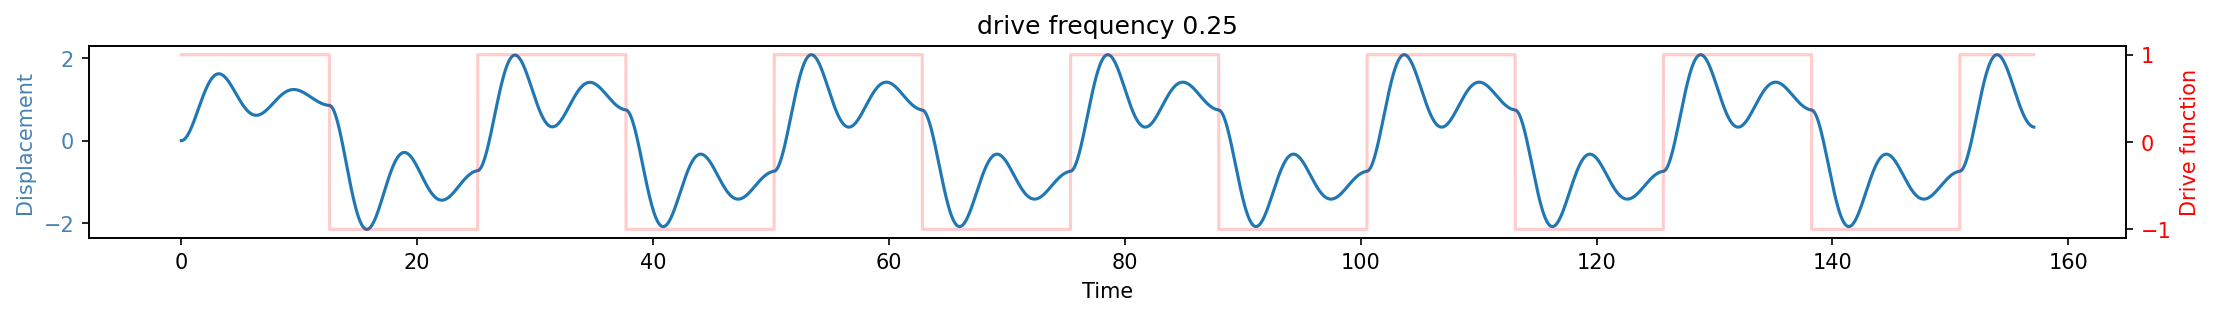

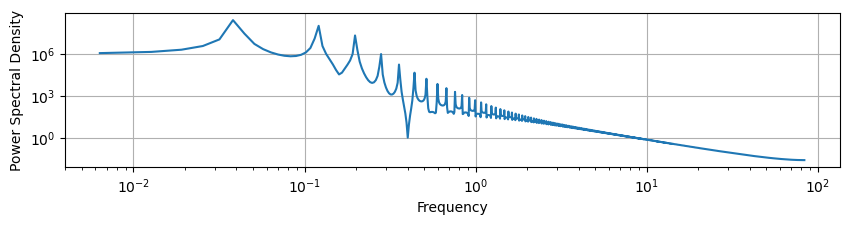

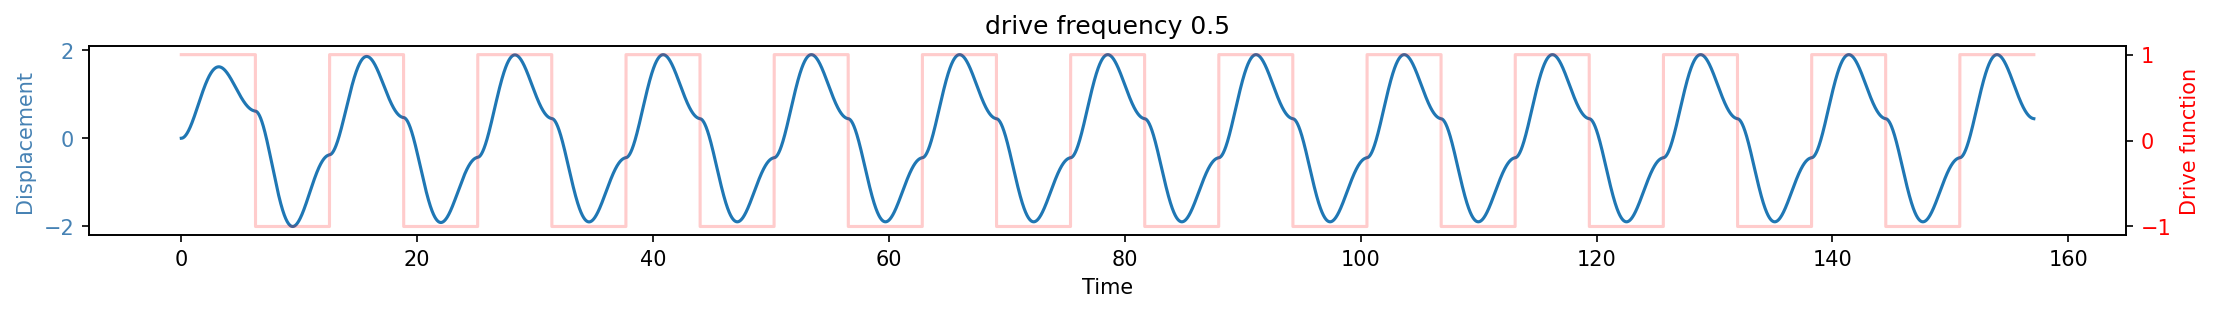

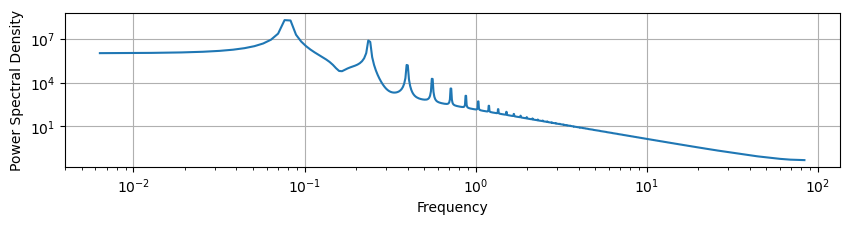

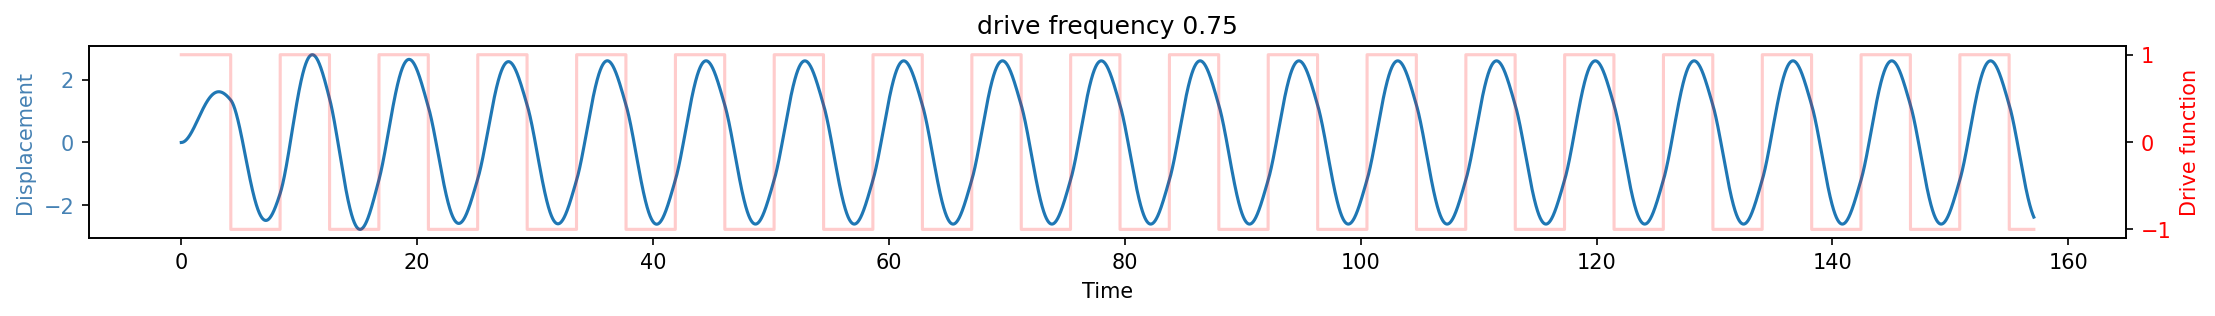

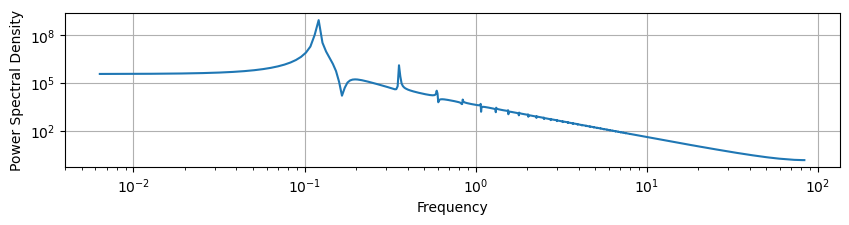

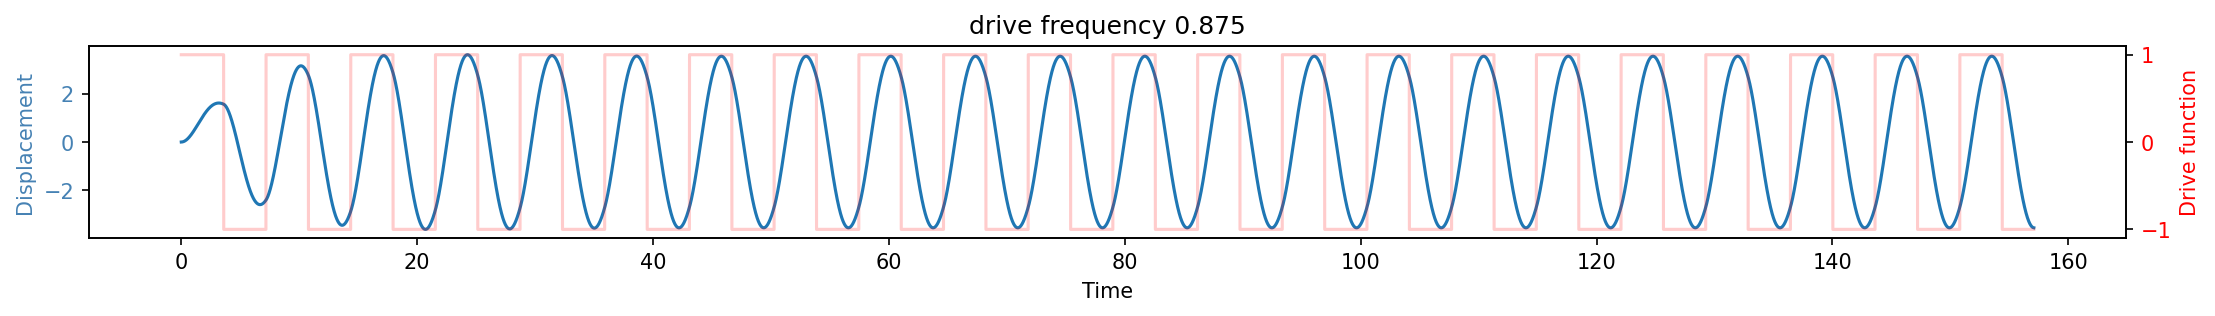

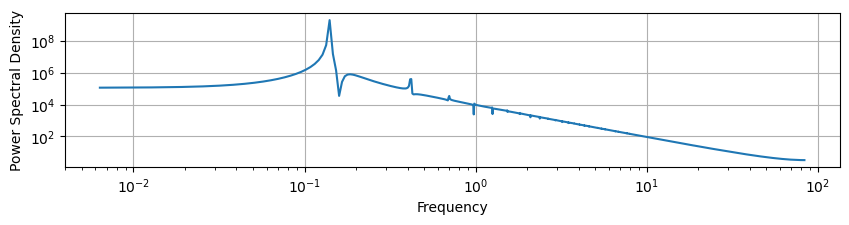

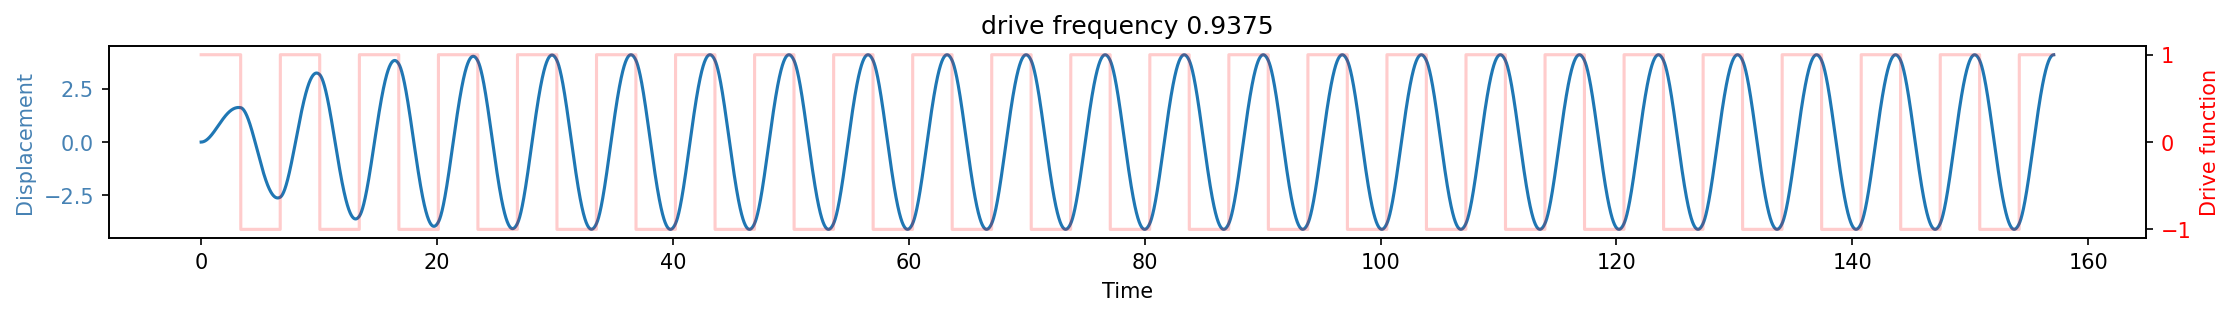

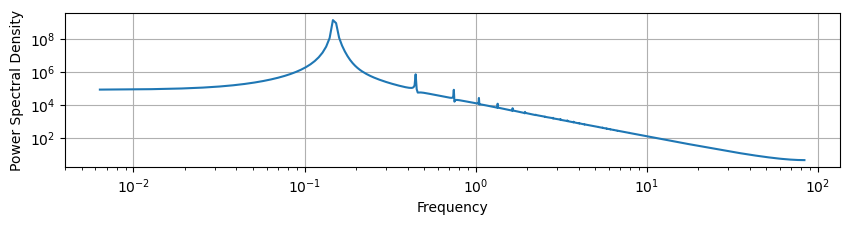

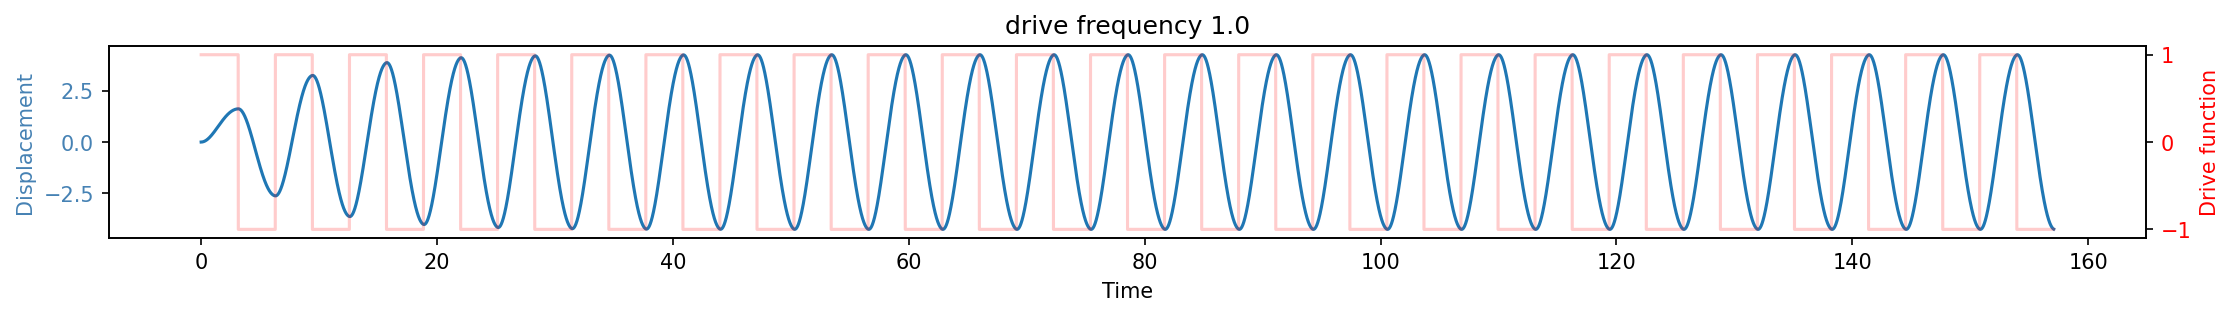

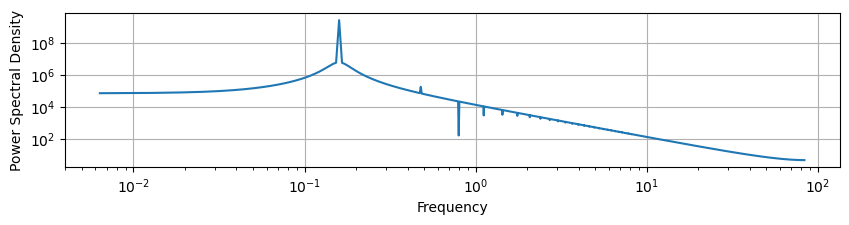

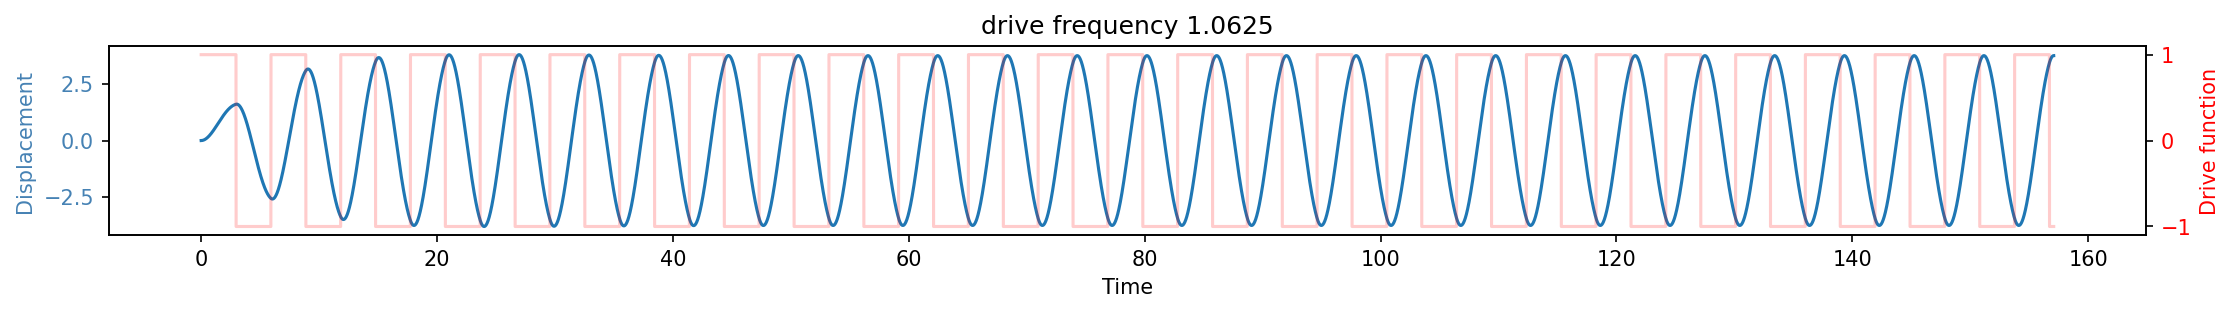

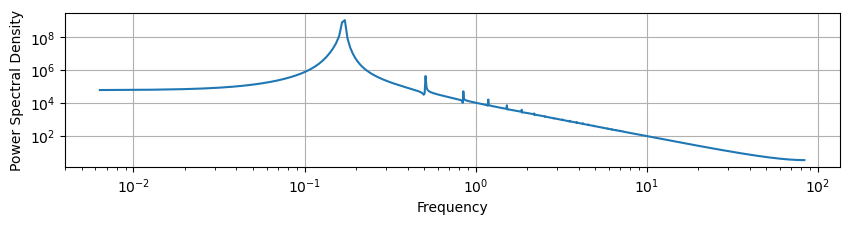

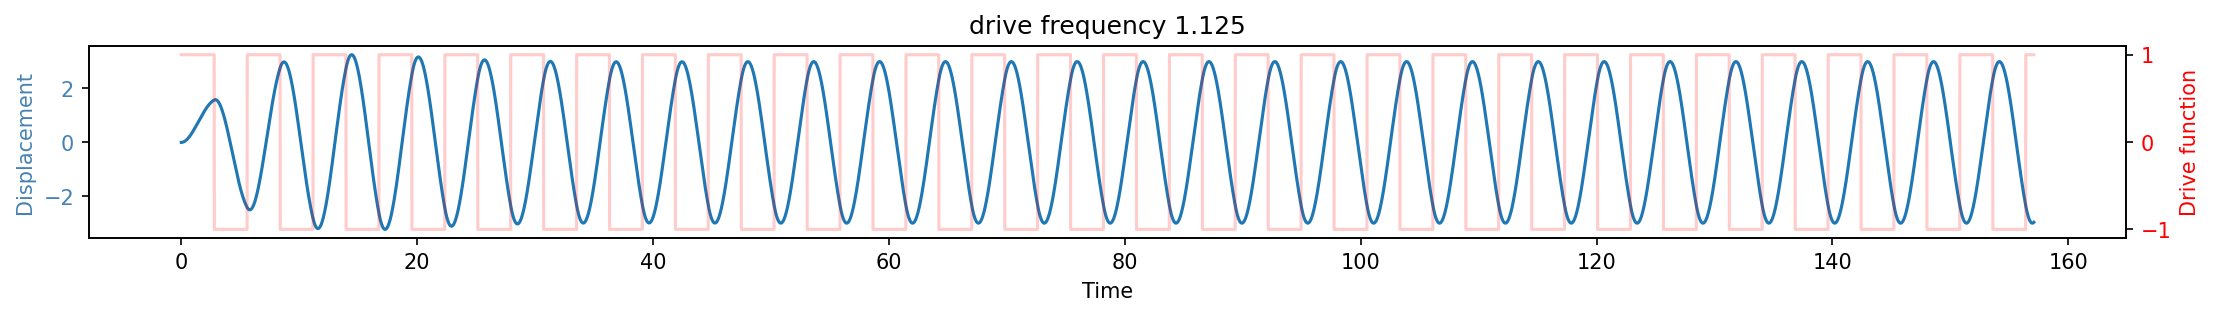

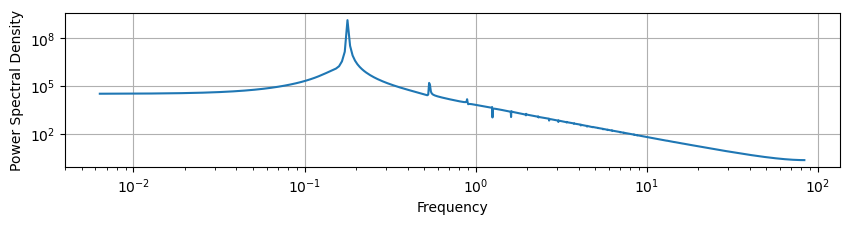

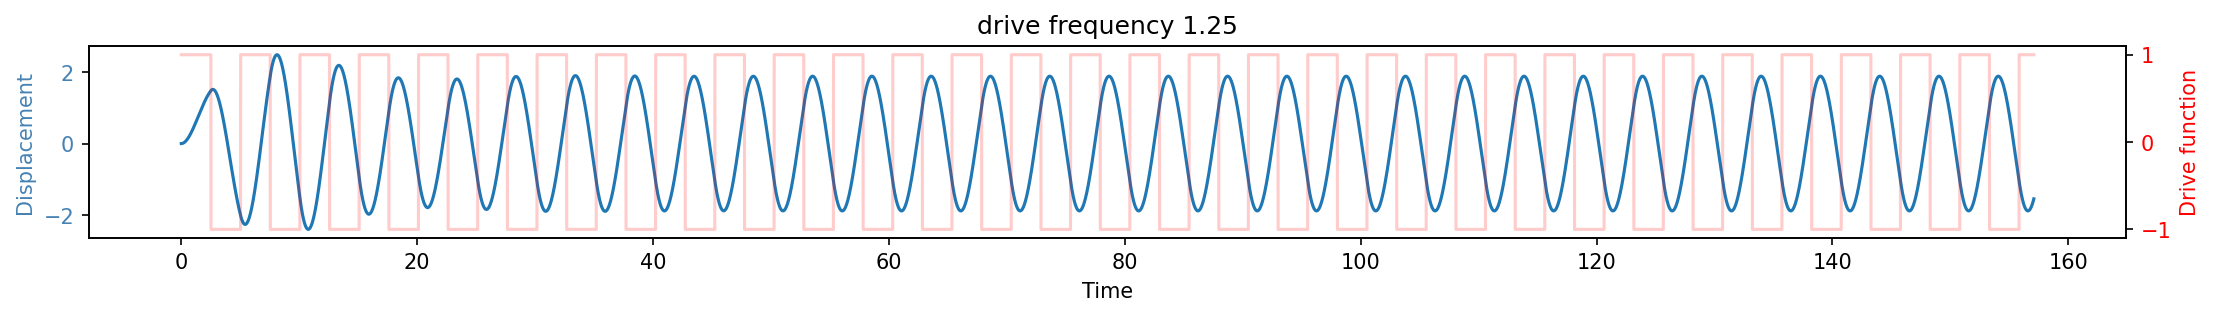

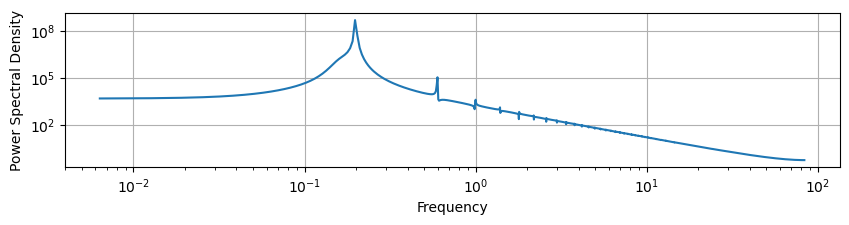

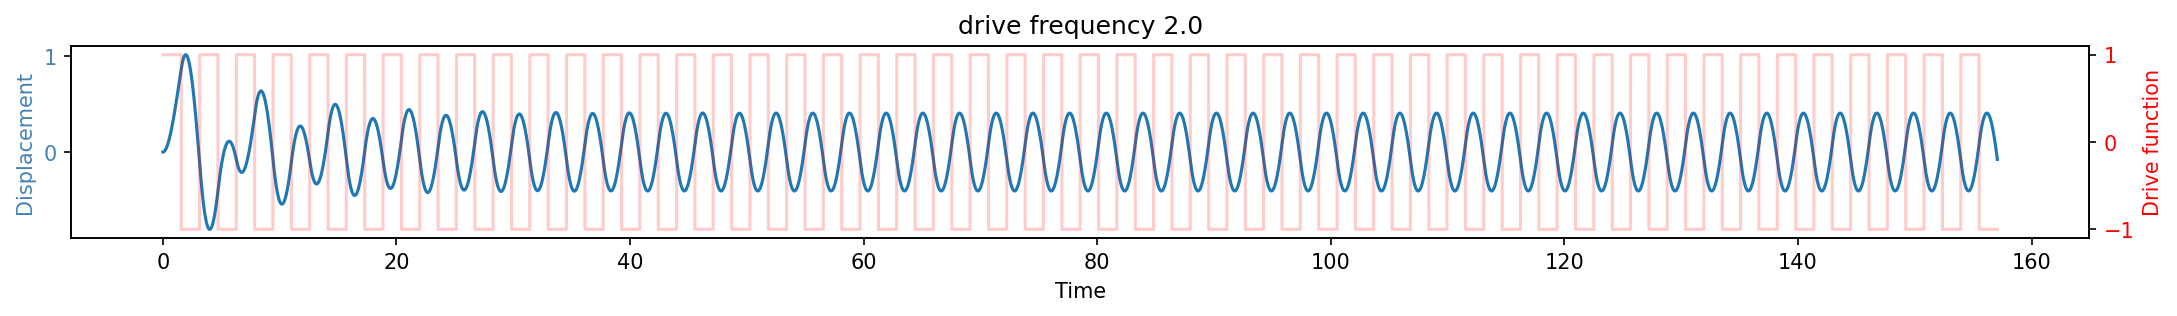

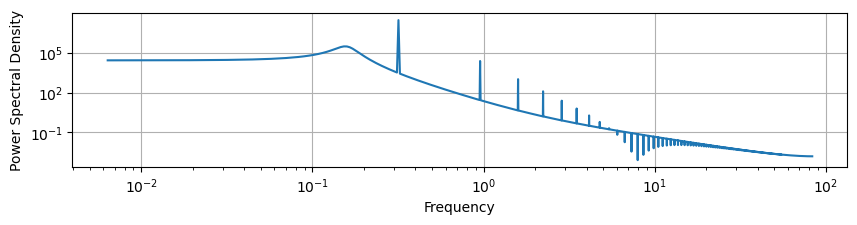

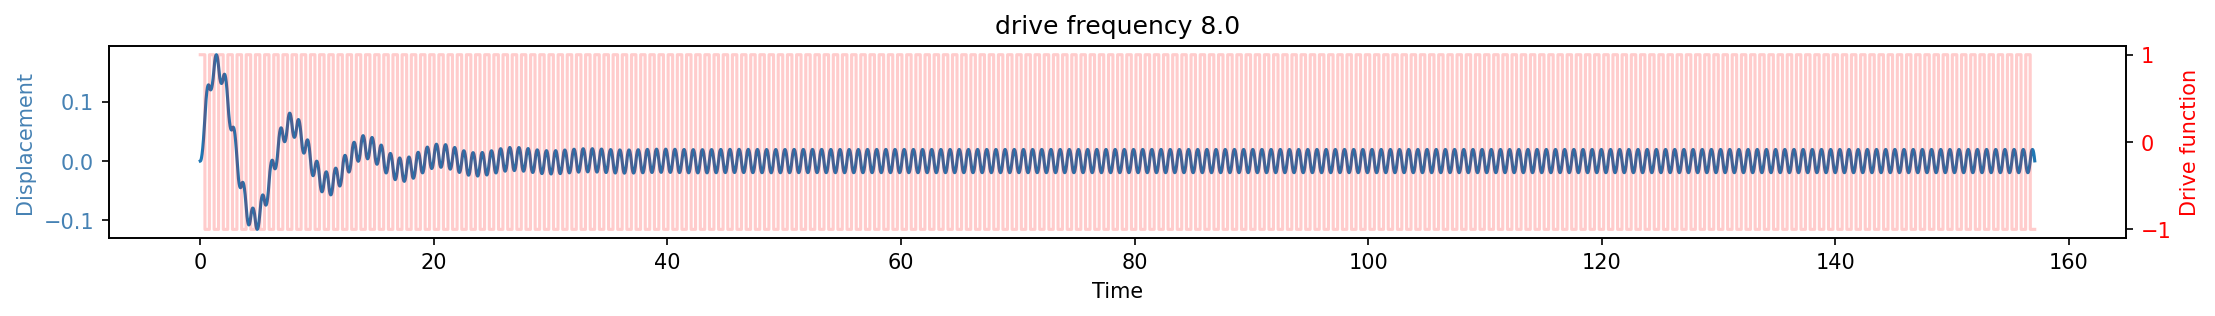

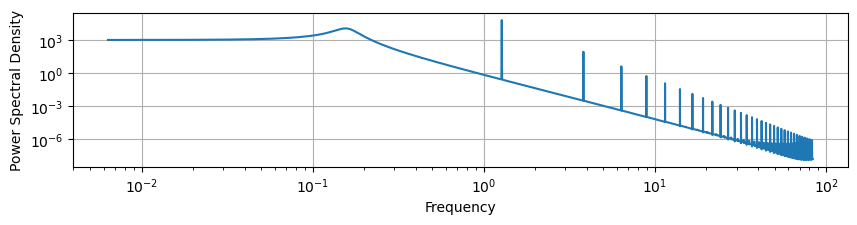

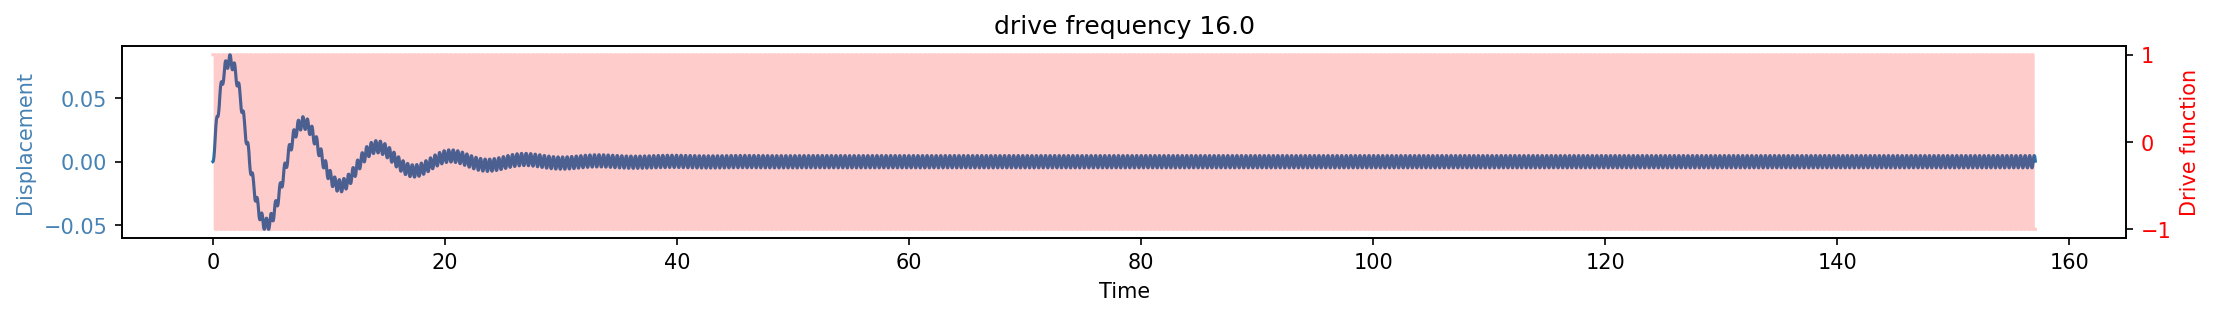

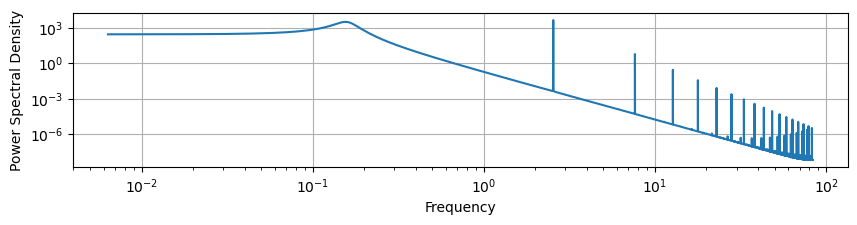

In [36]:
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]
    drive_freq = drive_frequency_array[i]
    utils.plot_obsesrvable_and_drive(traj, 
                                     drive_array = drive_array, 
                                     t_array = t_array)
    plt.title(f"drive frequency {drive_freq}")
    utils.plot_power_spectrum(t_array, traj)

In [37]:
### Save simulation as CSV

df = pd.DataFrame()
df['time'] = t_array

# Loop over the drive frequency array
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]

    # Create new columns for each drive_freq
    df[f'square_drive_{drive_freq}'] = drive_array
    df[f'response_under_{drive_freq}'] = traj

df.to_csv('simulated_data/Harmonic_oscillator_noiseless.csv', index=False)

df

time square_drive_0.25  response_under_0.25 square_drive_0.5  \
0        0.000               1.0             0.000000              1.0   
1        0.006               1.0             0.000018              1.0   
2        0.012               1.0             0.000072              1.0   
3        0.018               1.0             0.000162              1.0   
4        0.024               1.0             0.000287              1.0   
...        ...               ...                  ...              ...   
26175  157.050               1.0             0.330299              1.0   
26176  157.056               1.0             0.329975              1.0   
26177  157.062               1.0             0.329675              1.0   
26178  157.068               1.0             0.329400              1.0   
26179  157.074               1.0             0.329149              1.0   

       response_under_0.5 square_drive_0.75  response_under_0.75  \
0                0.000000               1.0             0.000000   
1                0.000018               1.0             0.000018   
2                0.000072               1.0             0.000072   
3                0.000162               1.0             0.000162   
4                0.000287               1.0             0.000287   
...                   ...               ...                  ...   
26175            0.445110              -1.0            -2.362545   
26176            0.444845              -1.0            -2.367934   
26177            0.444601              -1.0            -2.373264   
26178            0.444377              -1.0            -2.378535   
26179            0.444173              -1.0            -2.383747   

      square_drive_0.875  response_under_0.875 square_drive_0.9375  ...  \
0                    1.0              0.000000                 1.0  ...   
1                    1.0              0.000018                 1.0  ...   
2                    1.0              0.000072                 1.0  ...   
3                    1.0              0.000162                 1.0  ...   
4                    1.0              0.000287                 1.0  ...   
...                  ...                   ...                 ...  ...   
26175               -1.0             -3.564157                 1.0  ...   
26176               -1.0             -3.564829                 1.0  ...   
26177               -1.0             -3.565407                 1.0  ...   
26178               -1.0             -3.565892                 1.0  ...   
26179               -1.0             -3.566284                 1.0  ...   

       square_drive_1.125 response_under_1.125  square_drive_1.25  \
0                     1.0             0.000000                1.0   
1                     1.0             0.000018                1.0   
2                     1.0             0.000072                1.0   
3                     1.0             0.000162                1.0   
4                     1.0             0.000287                1.0   
...                   ...                  ...                ...   
26175                 1.0            -2.975985                1.0   
26176                 1.0            -2.973523                1.0   
26177                 1.0            -2.970922                1.0   
26178                 1.0            -2.968183                1.0   
26179                 1.0            -2.965306                1.0   

      response_under_1.25  square_drive_2.0 response_under_2.0  \
0                0.000000               1.0           0.000000   
1                0.000018               1.0           0.000018   
2                0.000072               1.0           0.000072   
3                0.000162               1.0           0.000162   
4                0.000287               1.0           0.000287   
...                   ...               ...                ...   
26175           -1.577302              -1.0          -0.053975   
26176           -1.569868              -1.0   

**Case 2: Brownian noise in velocity and displacement, integrated using Euler–Maruyama method**

In [38]:
sigma_x = 0.2
sigma_v = 0.2

np.random.seed(1)

drive_list = []
simulated_trajectory_list = []

for drive_f in drive_frequency_array:
    drive_func = drive_with_f(drive_f)
    oscillator = HR_Oscillators.Harmonic_Oscillator(drive_func, gamma=0.3, sigma_x=sigma_x, sigma_v=sigma_v)
    x_array, t_array = oscillator.run_with_noise([0, 0], T=T, dt=dt)
    drive_array = [drive_func(t) for t in t_array]

    simulated_trajectory_list += [x_array]
    drive_list += [drive_array]

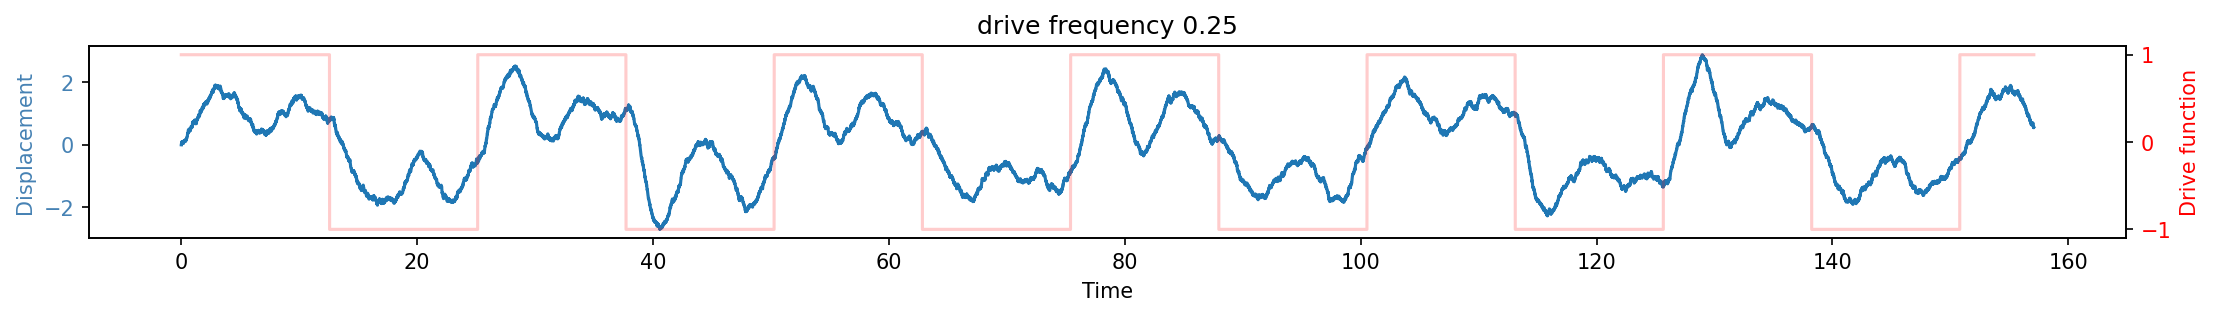

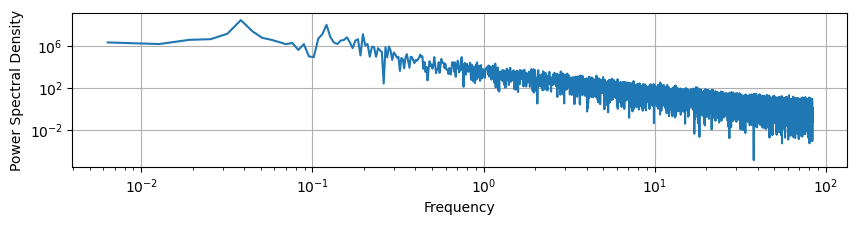

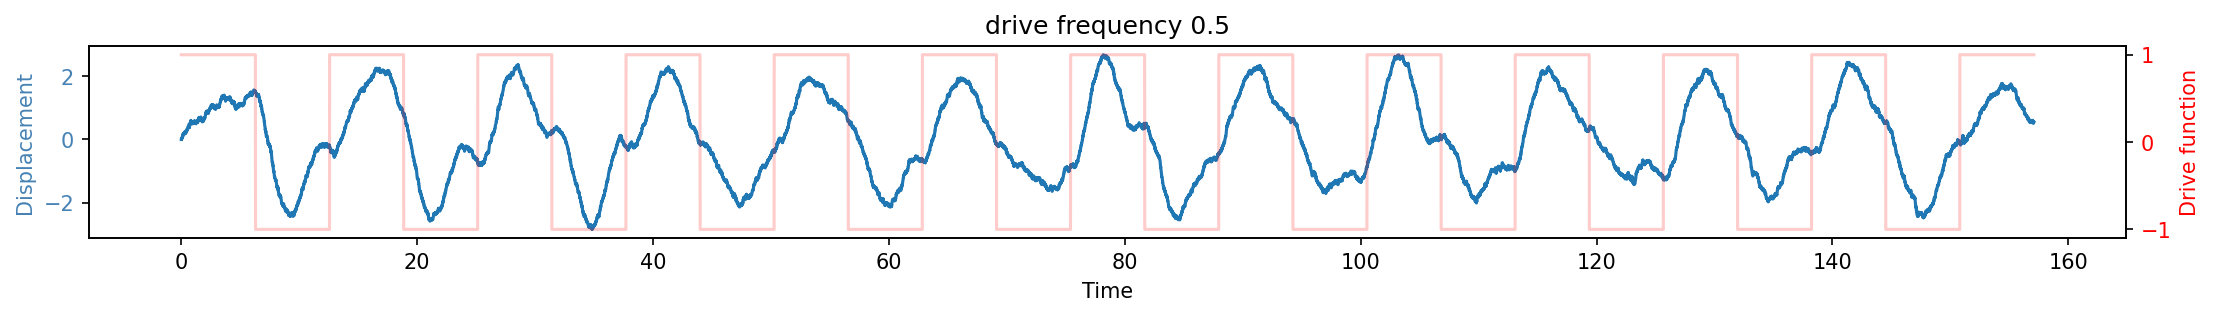

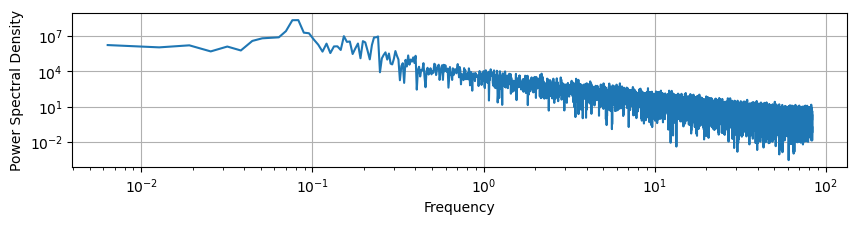

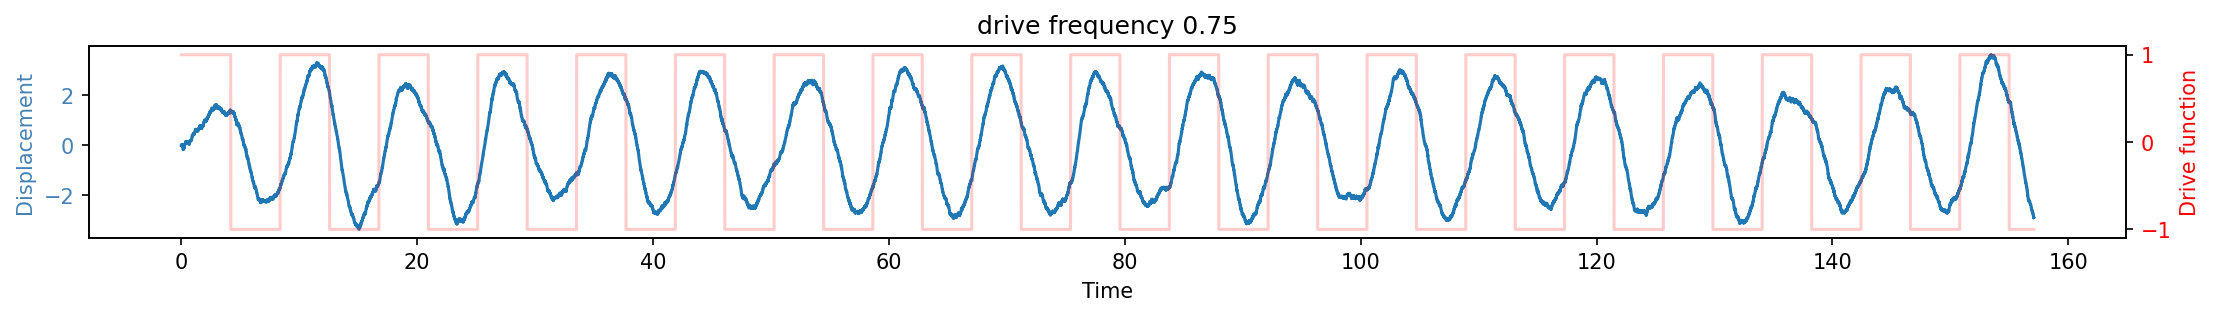

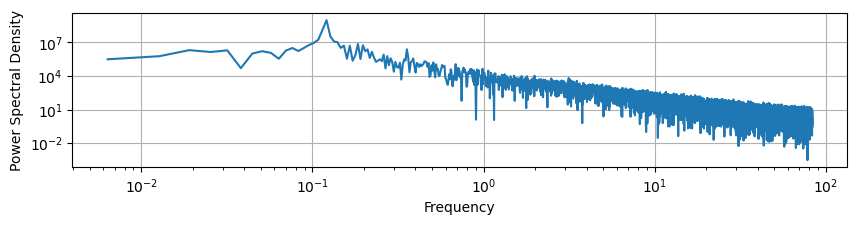

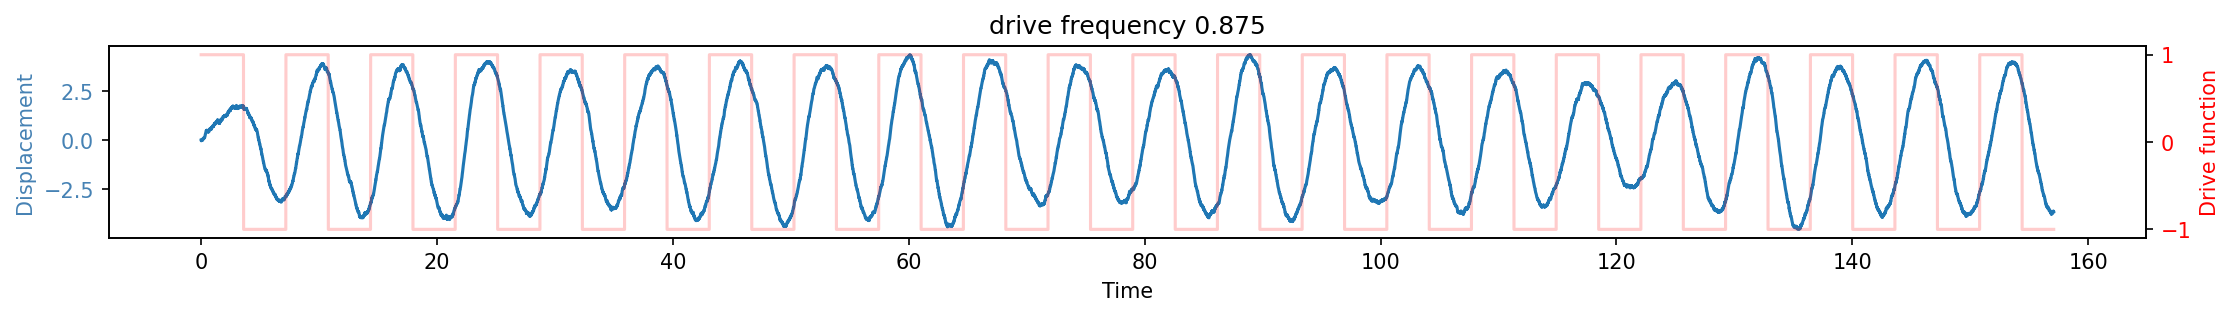

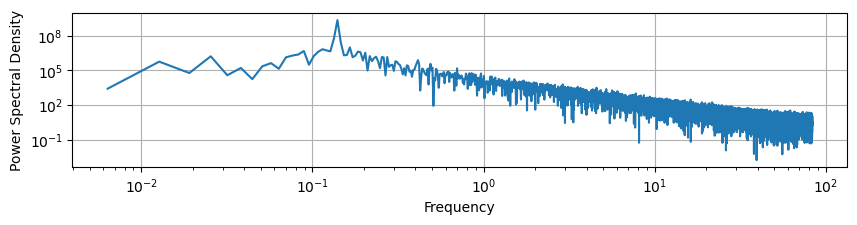

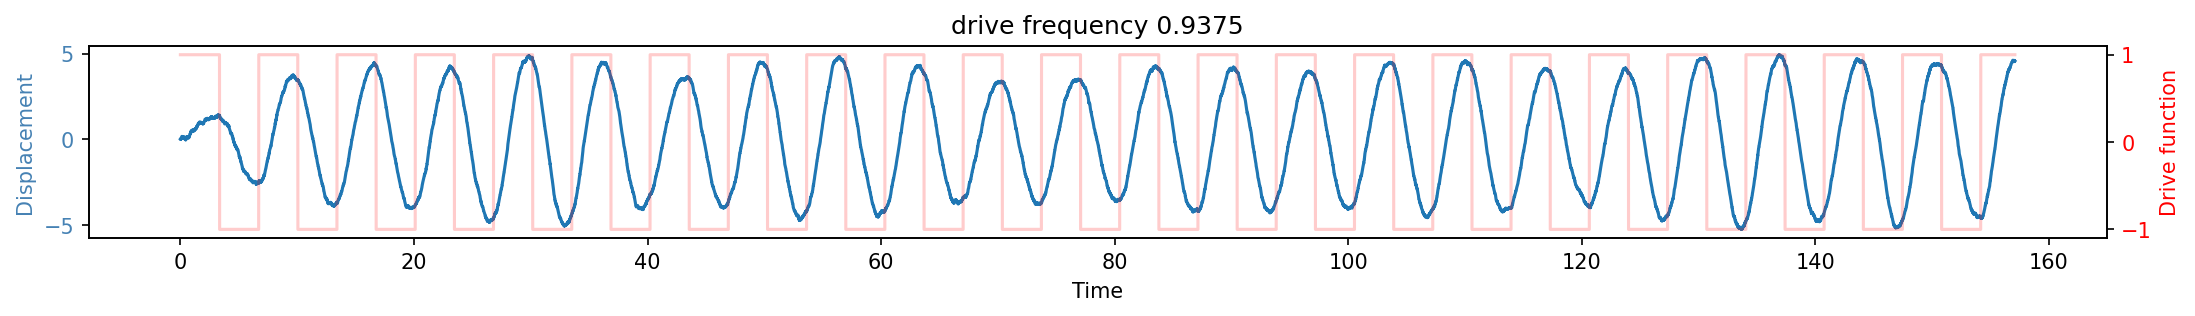

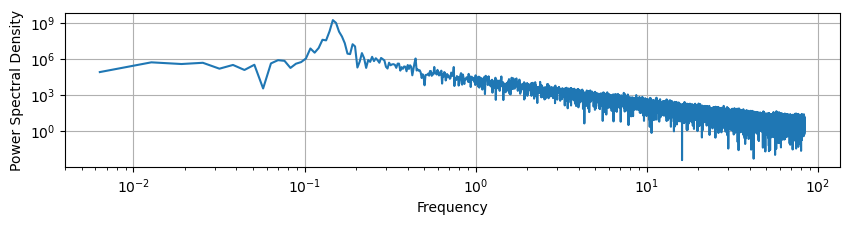

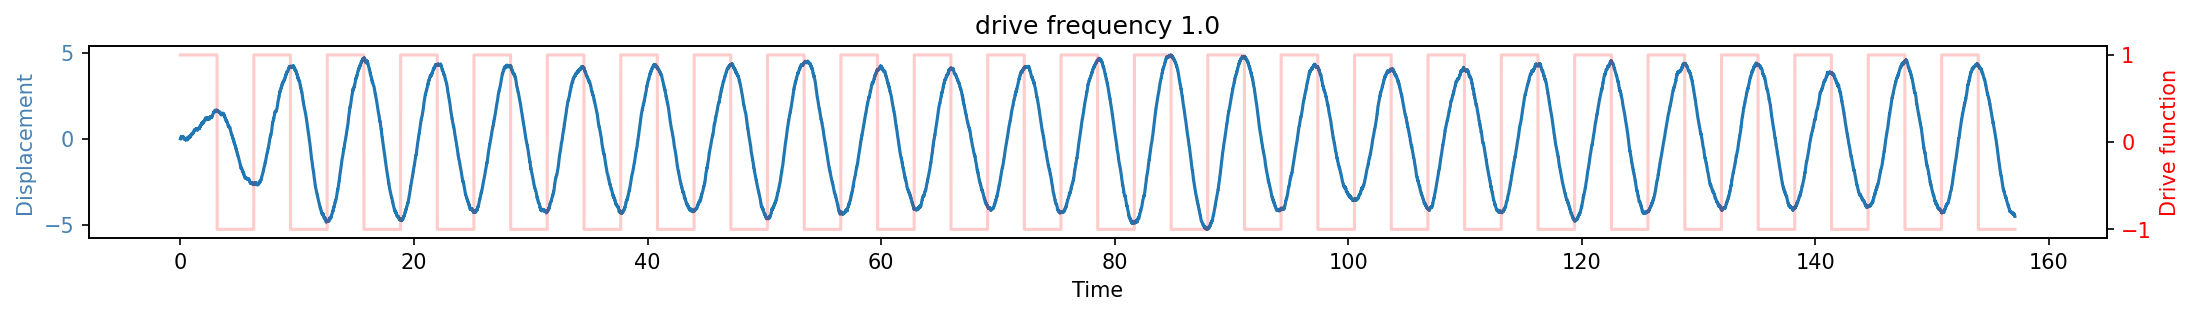

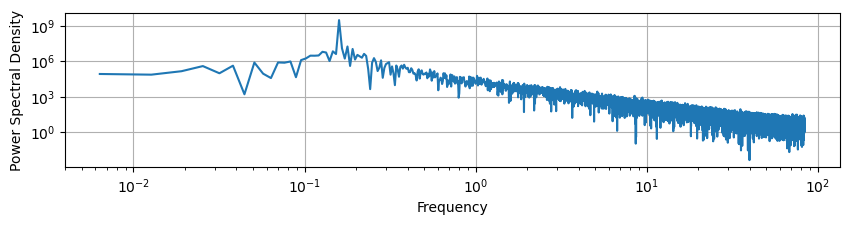

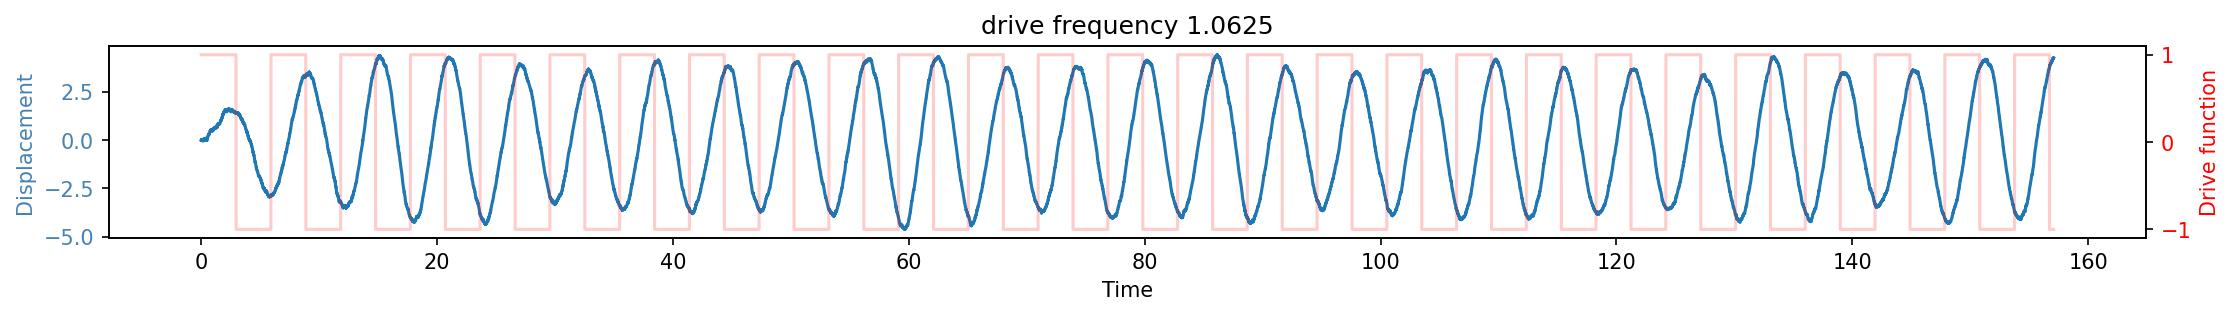

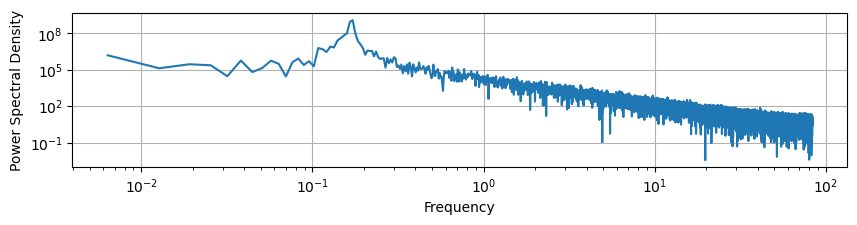

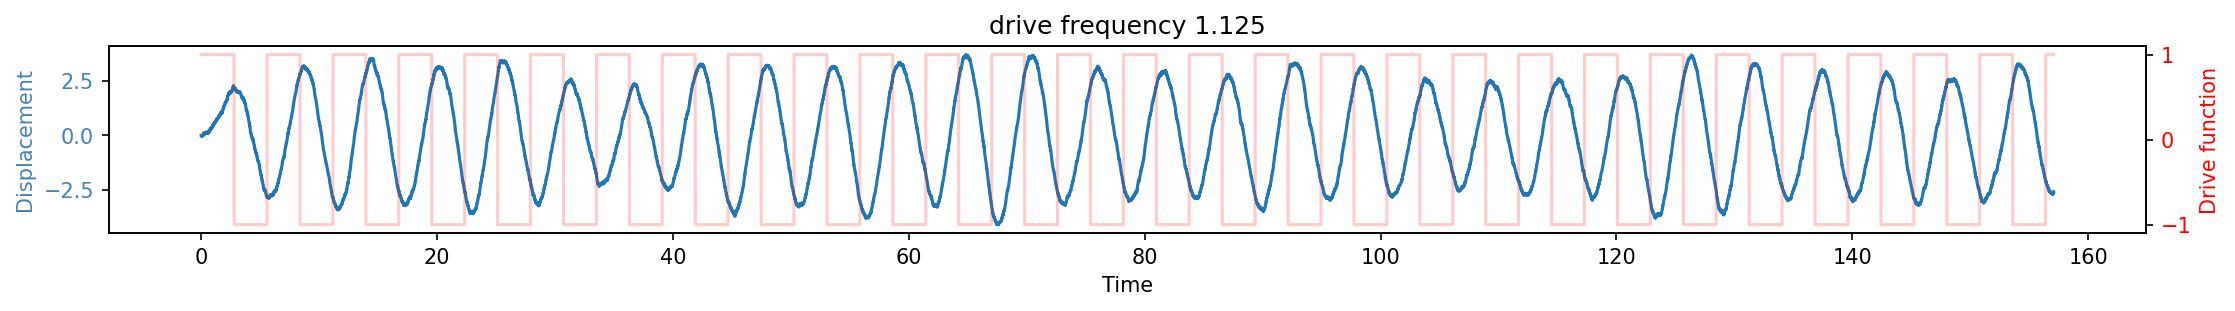

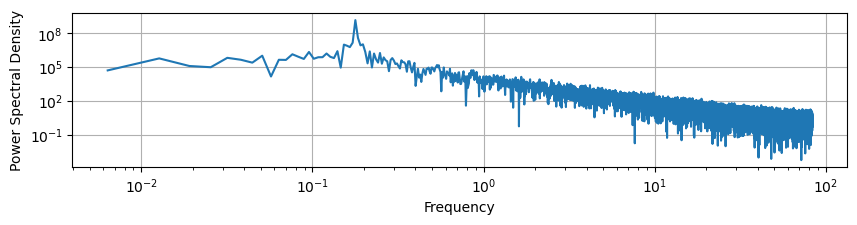

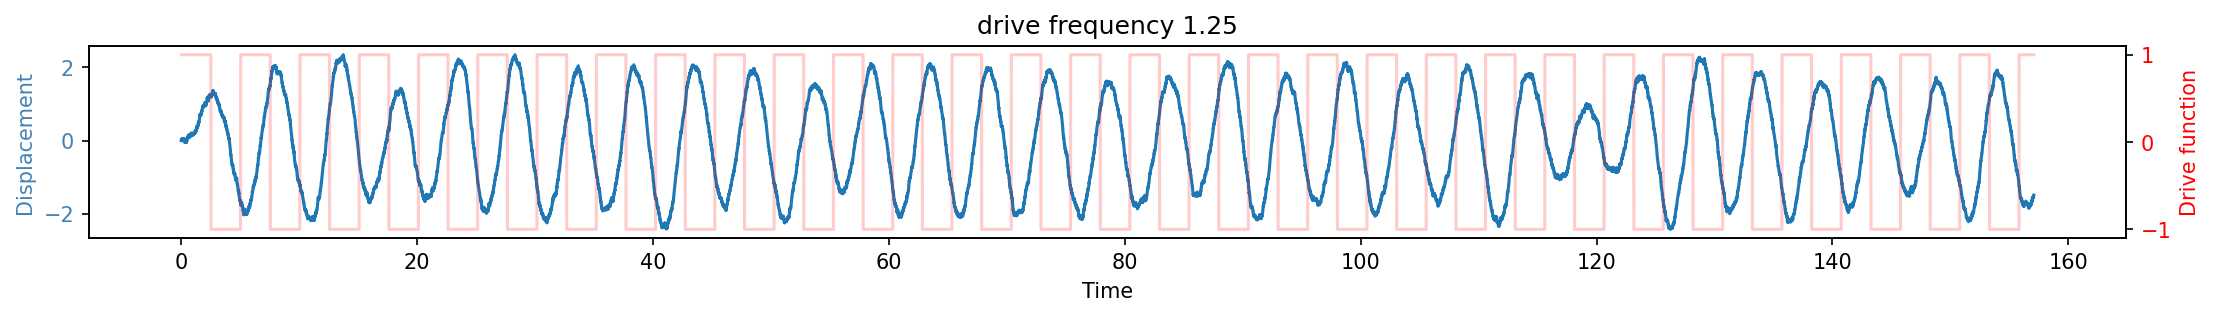

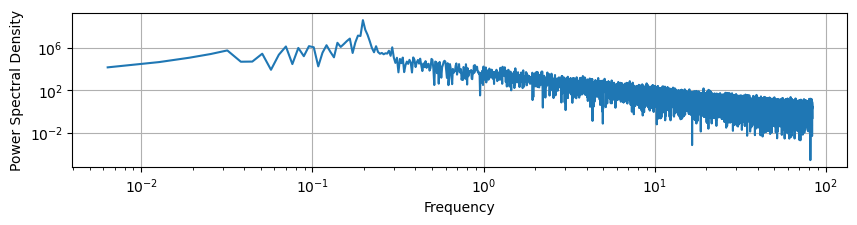

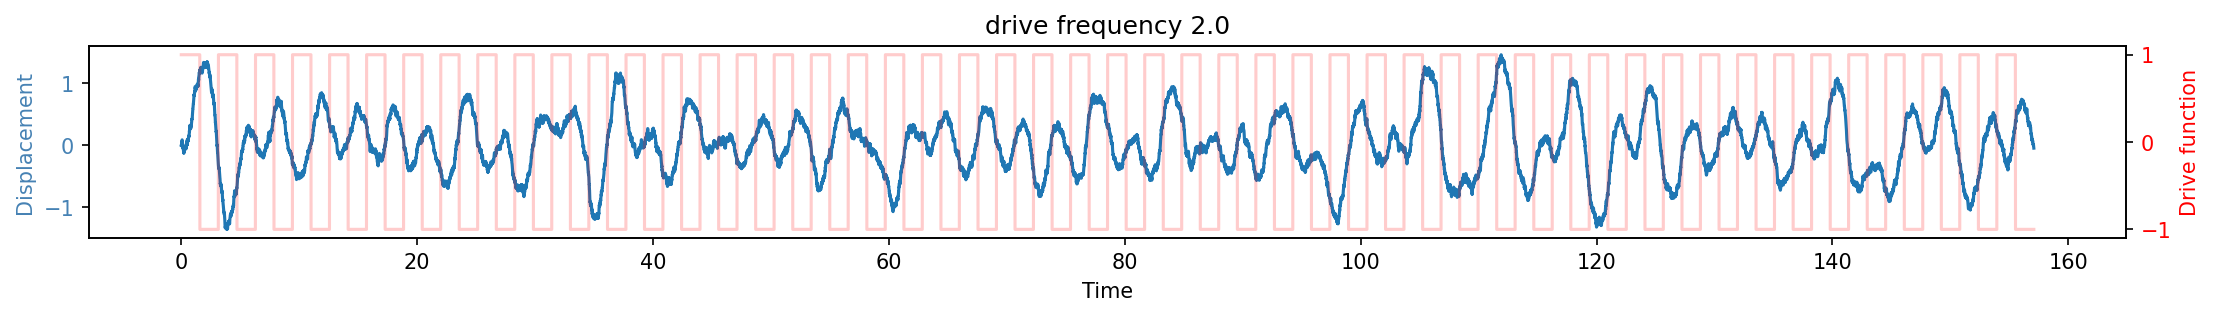

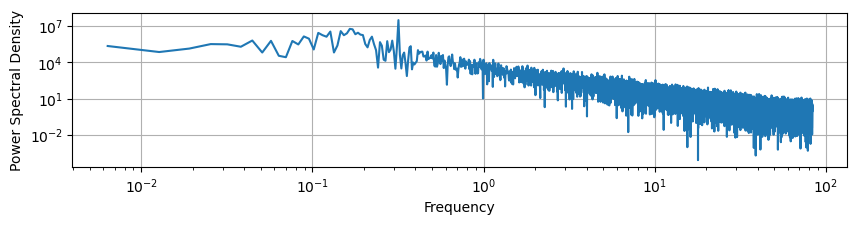

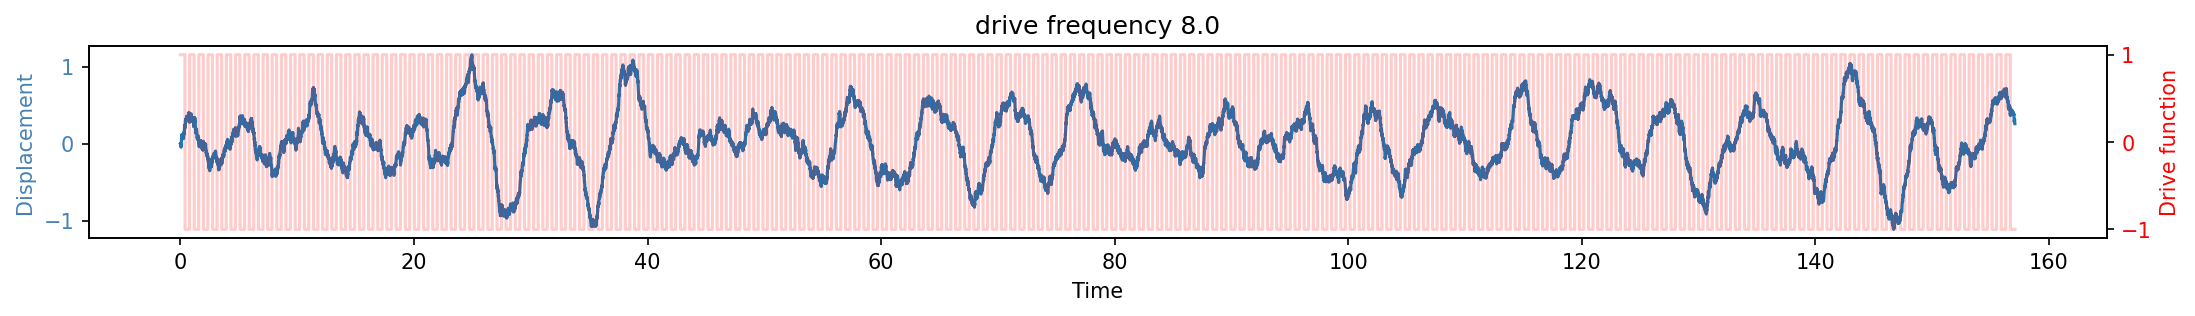

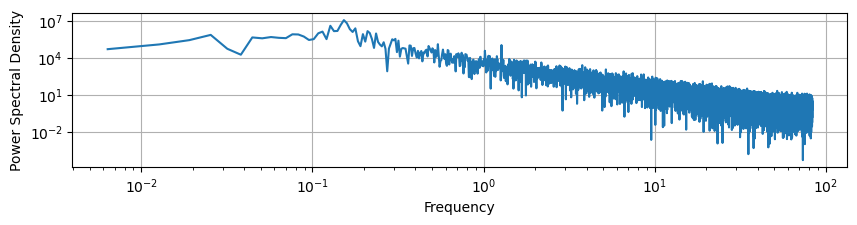

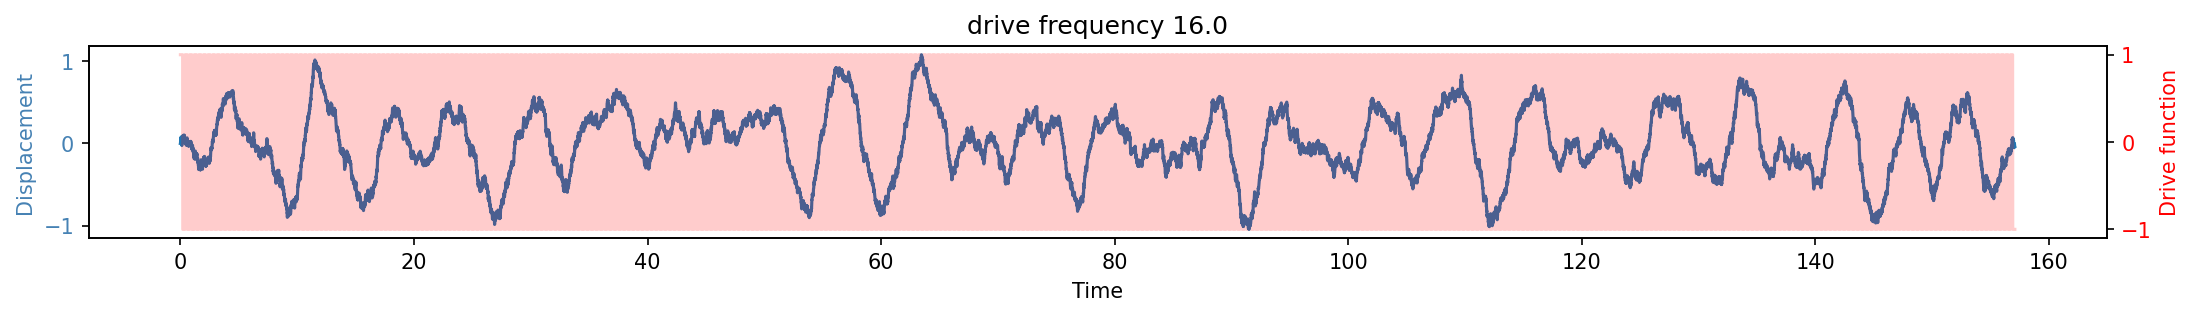

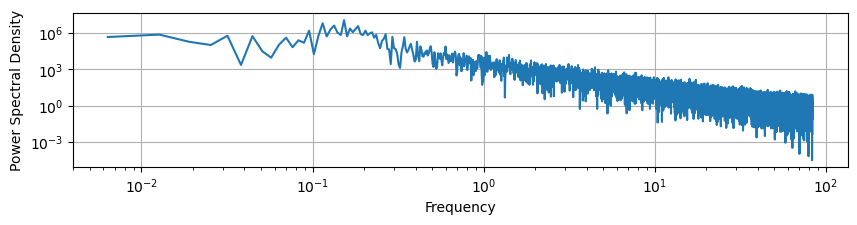

In [39]:
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]
    drive_freq = drive_frequency_array[i]
    utils.plot_obsesrvable_and_drive(traj, 
                                     drive_array = drive_array, 
                                     t_array = t_array)
    plt.title(f"drive frequency {drive_freq}")
    utils.plot_power_spectrum(t_array, traj)


In [40]:
### Save simulation as CSV

df = pd.DataFrame()
df['time'] = t_array

# Loop over the drive frequency array
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]

    # Create new columns for each drive_freq
    df[f'square_drive_{drive_freq}'] = drive_array
    df[f'response_under_{drive_freq}'] = traj

df.to_csv('simulated_data/Harmonic_oscillator_with_noise.csv', index=False)

df

time square_drive_0.25  response_under_0.25 square_drive_0.5  \
0        0.000               1.0             0.000000              1.0   
1        0.006               1.0             0.025164              1.0   
2        0.012               1.0             0.016961              1.0   
3        0.018               1.0             0.030282              1.0   
4        0.024               1.0             0.057049              1.0   
...        ...               ...                  ...              ...   
26175  157.050               1.0             0.568013              1.0   
26176  157.056               1.0             0.558834              1.0   
26177  157.062               1.0             0.545591              1.0   
26178  157.068               1.0             0.551234              1.0   
26179  157.074               1.0             0.554245              1.0   

       response_under_0.5 square_drive_0.75  response_under_0.75  \
0                0.000000               1.0             0.000000   
1                0.023397               1.0             0.021219   
2                0.028083               1.0             0.018469   
3                0.022755               1.0             0.008637   
4                0.025531               1.0             0.002870   
...                   ...               ...                  ...   
26175            0.564225              -1.0            -2.845957   
26176            0.565322              -1.0            -2.865159   
26177            0.550858              -1.0            -2.895613   
26178            0.541858              -1.0            -2.877525   
26179            0.546666              -1.0            -2.884560   

      square_drive_0.875  response_under_0.875 square_drive_0.9375  ...  \
0                    1.0              0.000000                 1.0  ...   
1                    1.0             -0.034526                 1.0  ...   
2                    1.0             -0.005470                 1.0  ...   
3                    1.0             -0.004863                 1.0  ...   
4                    1.0             -0.014132                 1.0  ...   
...                  ...                   ...                 ...  ...   
26175               -1.0             -3.661084                 1.0  ...   
26176               -1.0             -3.656300                 1.0  ...   
26177               -1.0             -3.645880                 1.0  ...   
26178               -1.0             -3.625875                 1.0  ...   
26179               -1.0             -3.649693                 1.0  ...   

       square_drive_1.125 response_under_1.125  square_drive_1.25  \
0                     1.0             0.000000                1.0   
1                     1.0             0.001068                1.0   
2                     1.0             0.000935                1.0   
3                     1.0            -0.005371                1.0   
4                     1.0            -0.013910                1.0   
...                   ...                  ...                ...   
26175                 1.0            -2.592015                1.0   
26176                 1.0            -2.590111                1.0   
26177                 1.0            -2.586139                1.0   
26178                 1.0            -2.569477                1.0   
26179                 1.0            -2.587688                1.0   

      response_under_1.25  square_drive_2.0 response_under_2.0  \
0                0.000000               1.0           0.000000   
1                0.026639               1.0           0.009578   
2               -0.000648               1.0          -0.007713   
3                0.003482               1.0          -0.008943   
4                0.009963               1.0           0.019541   
...                   ...               ...                ...   
26175           -1.538144              -1.0          -0.020926   
26176           -1.520714              -1.0   

### Radial Isochron Simulations
$$\begin{align}
dr = \alpha (\mu r dt -r^3 dt) + dw_r \\
d\phi =\omega dt+ k\,sin(F(t)-\phi) +dw_{\phi}
\end{align}
$$

wiht default setting:
- alpha = 0.1 
- 𝜔 = 1
- 𝜇 = 1
- k = 0.3

In [41]:
k = 0.5

**Case 1: noiseless integrated using odeint**

In [42]:
np.random.seed(1)

drive_list = []
simulated_trajectory_list = []

for drive_f in drive_frequency_array:
    drive_func = drive_with_f(drive_f)
    oscillator = HR_Oscillators.Radial_Oscillator(drive_func, k = k)
    x_array, t_array = oscillator.run_without_noise([1, 0], T=T, dt=dt)
    drive_array = [drive_func(t) for t in t_array]

    simulated_trajectory_list += [x_array]
    drive_list += [drive_array]

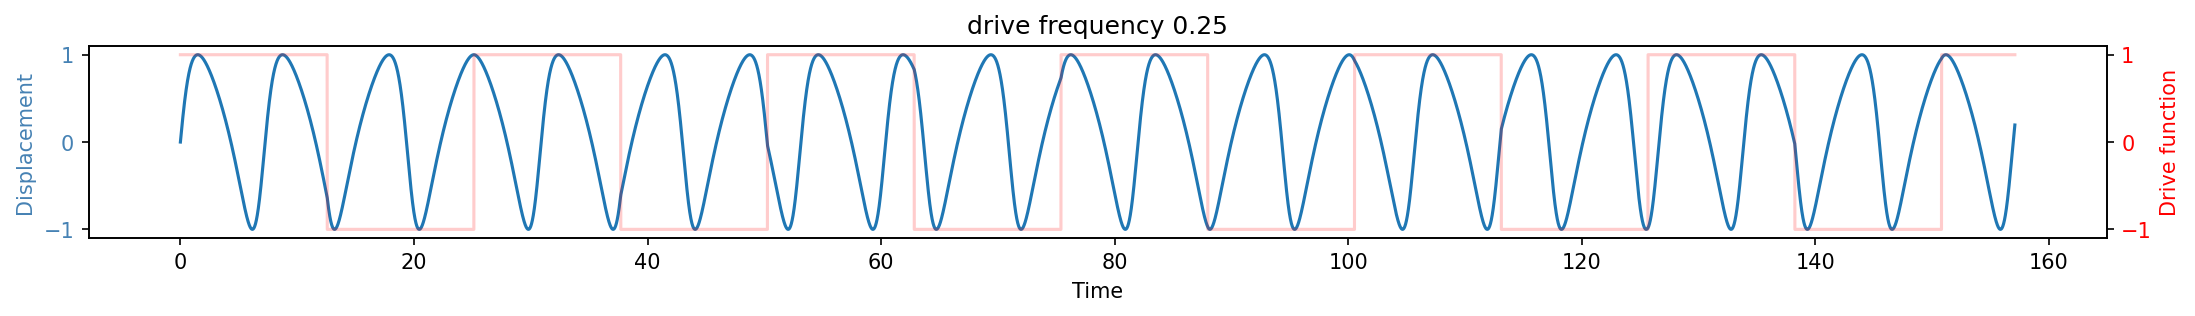

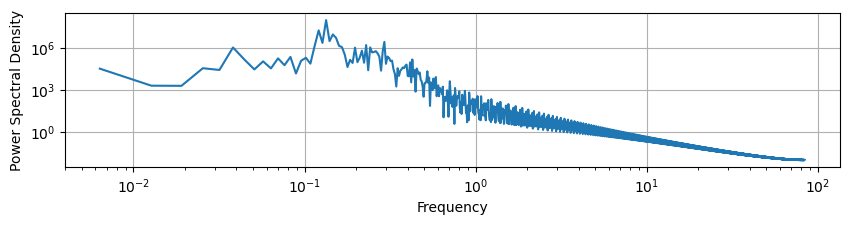

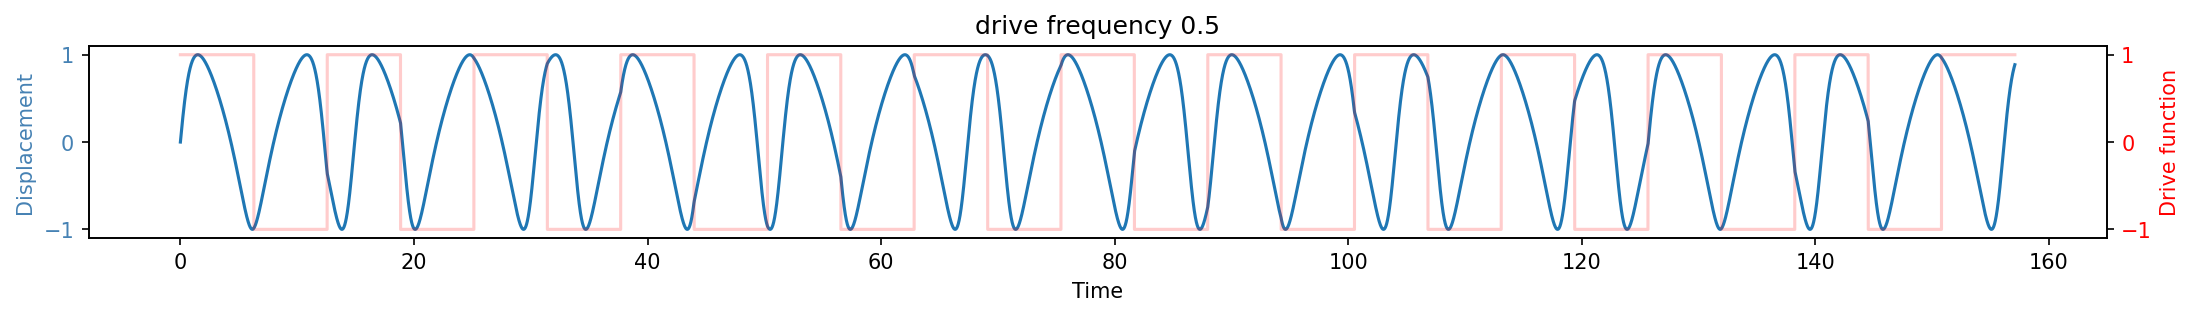

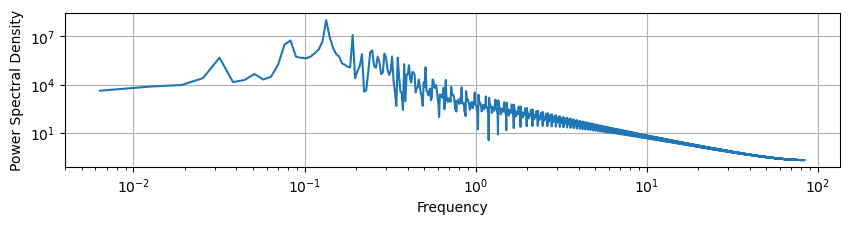

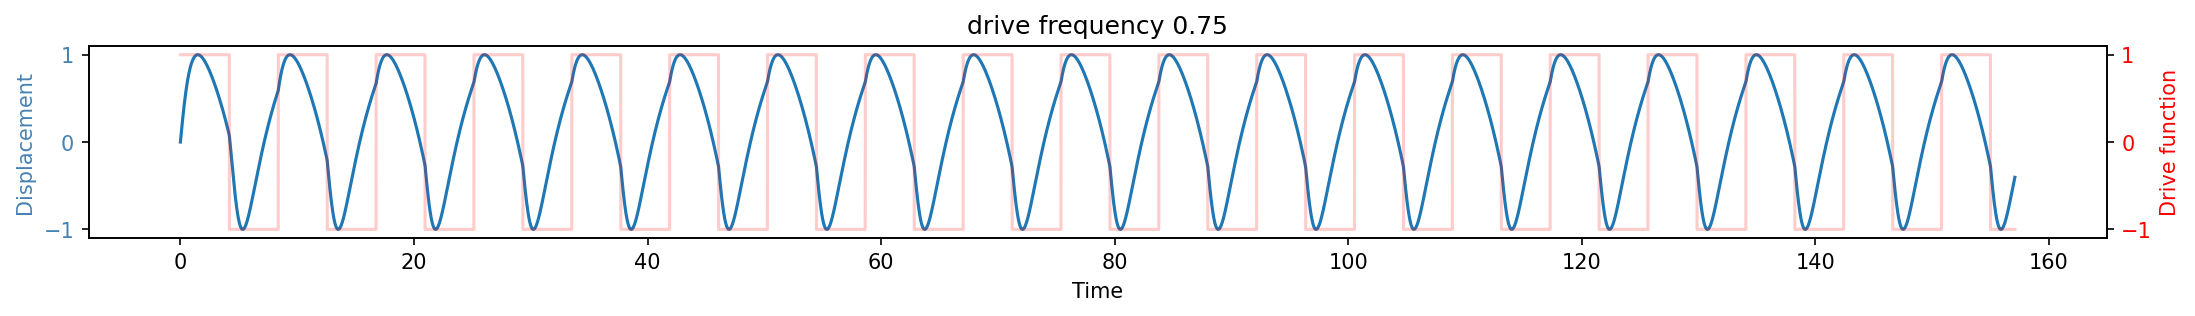

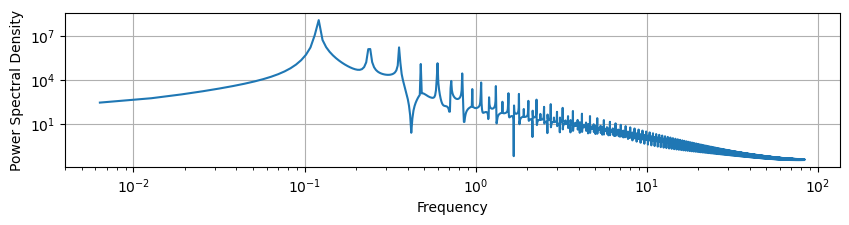

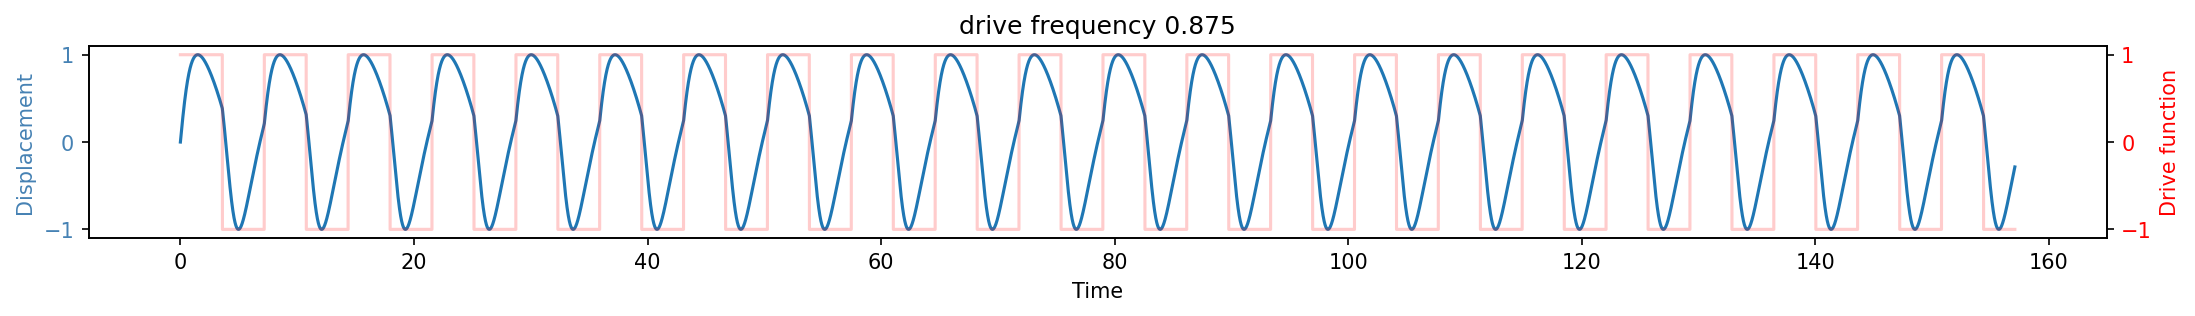

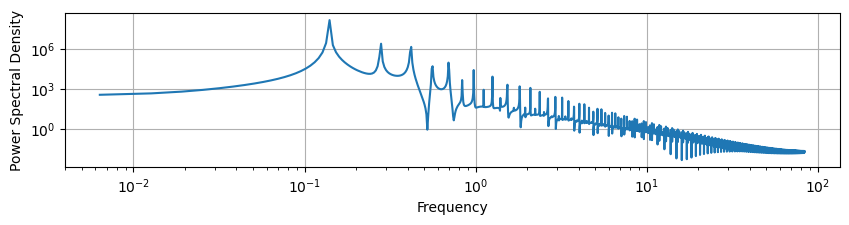

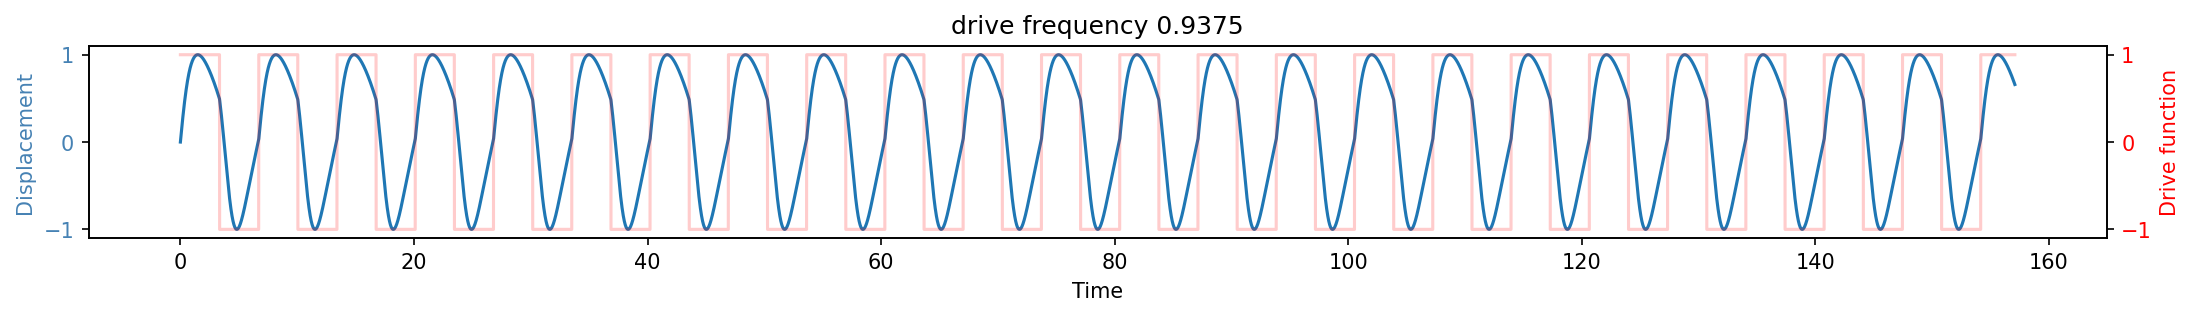

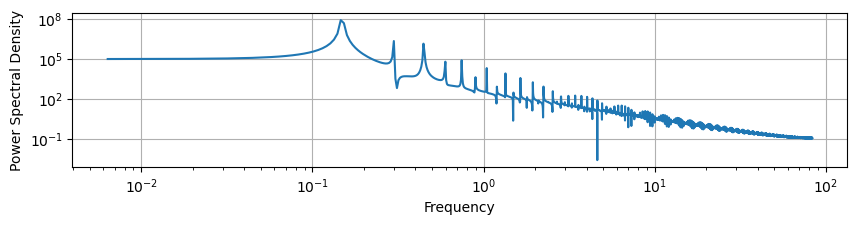

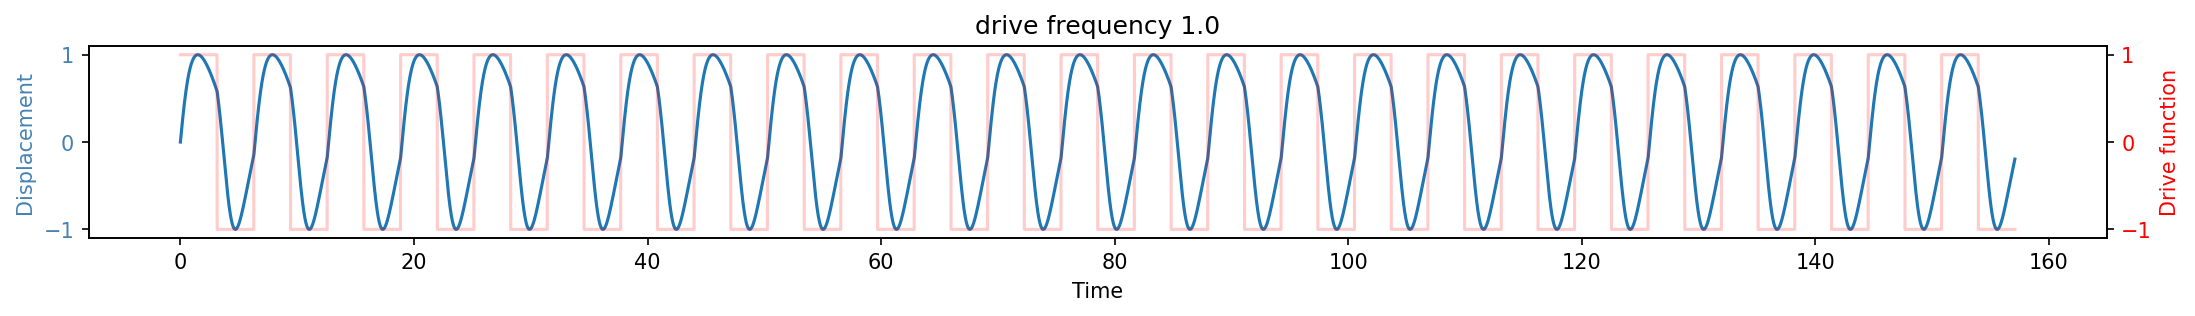

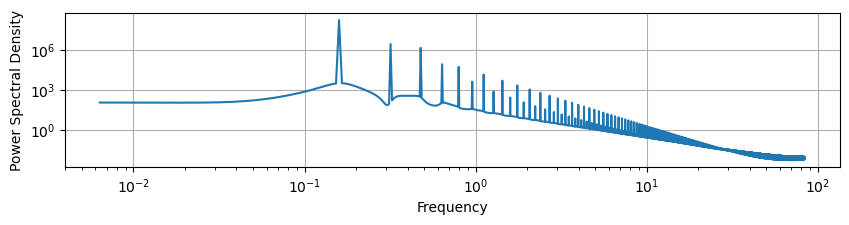

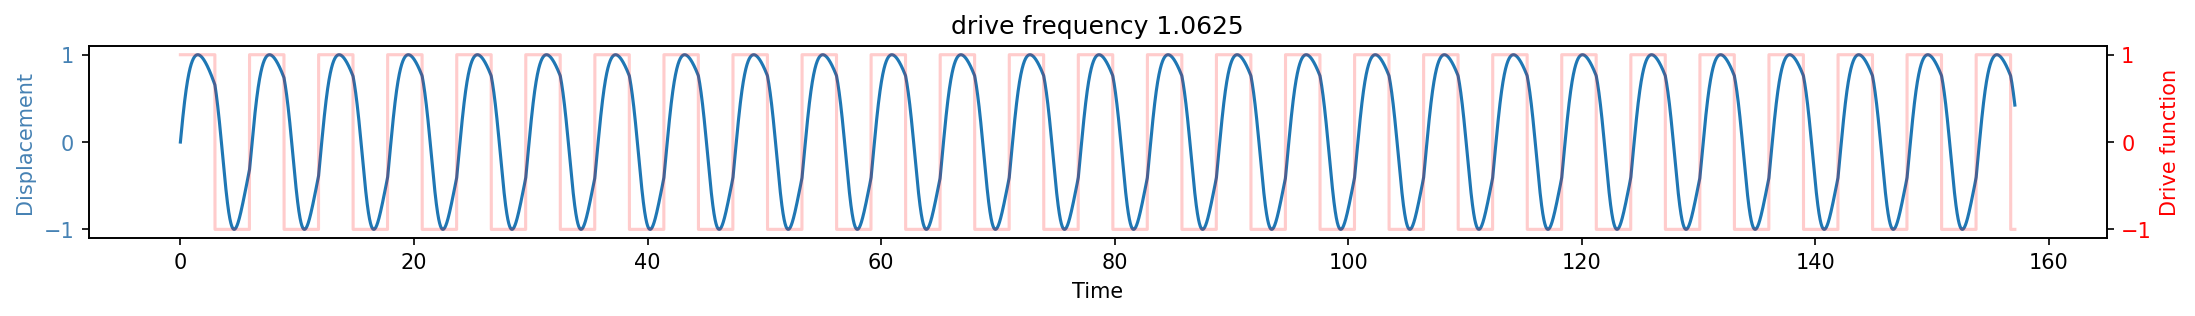

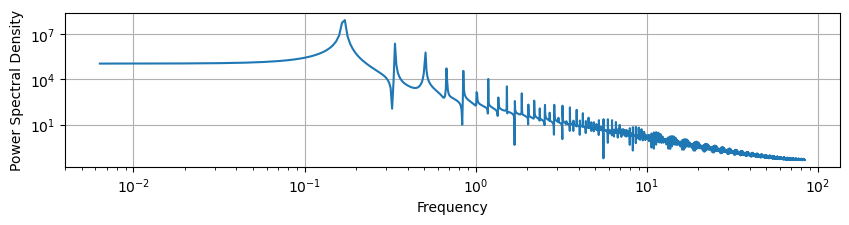

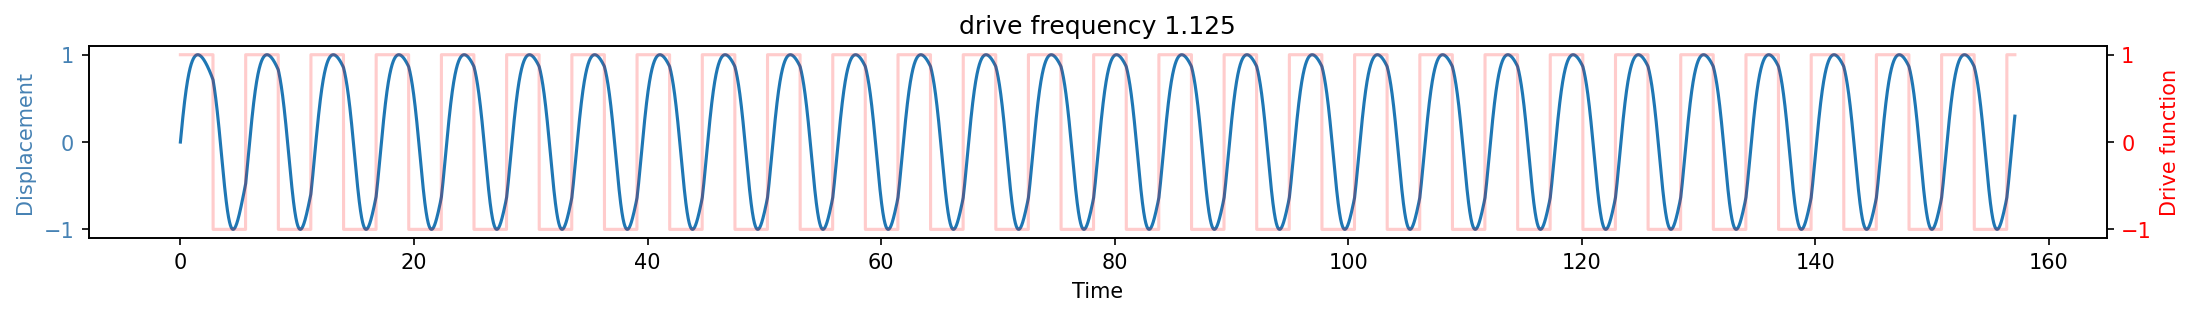

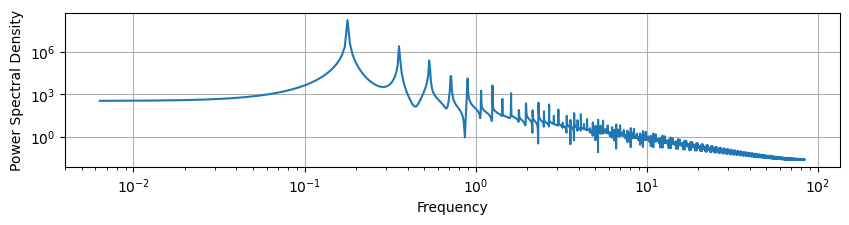

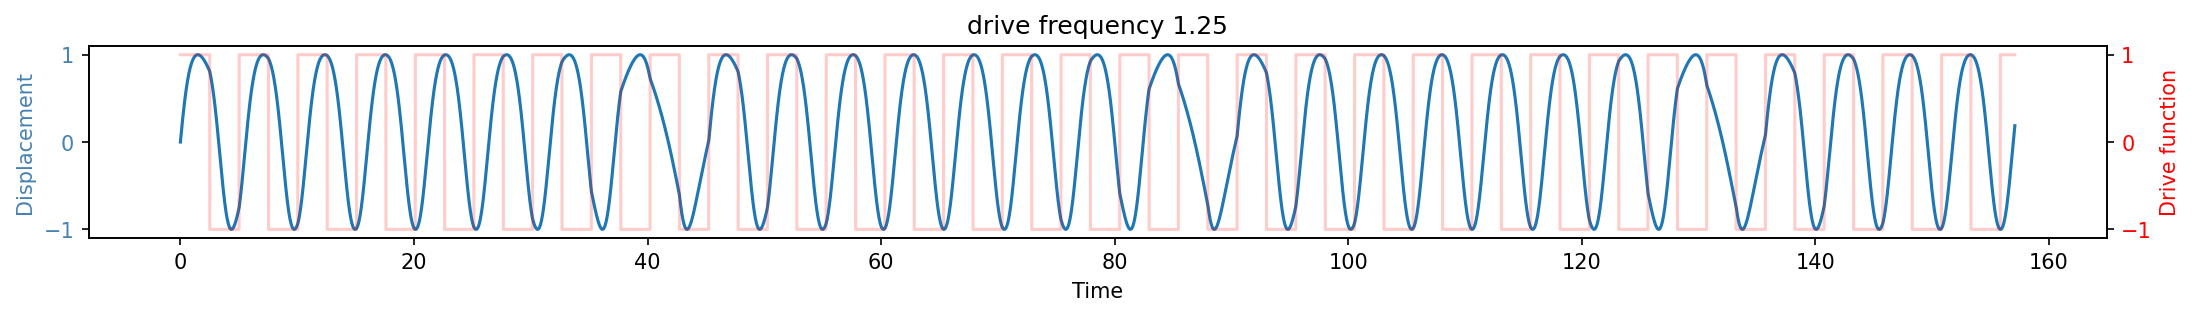

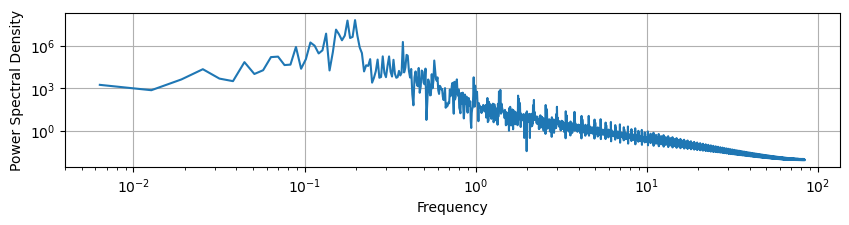

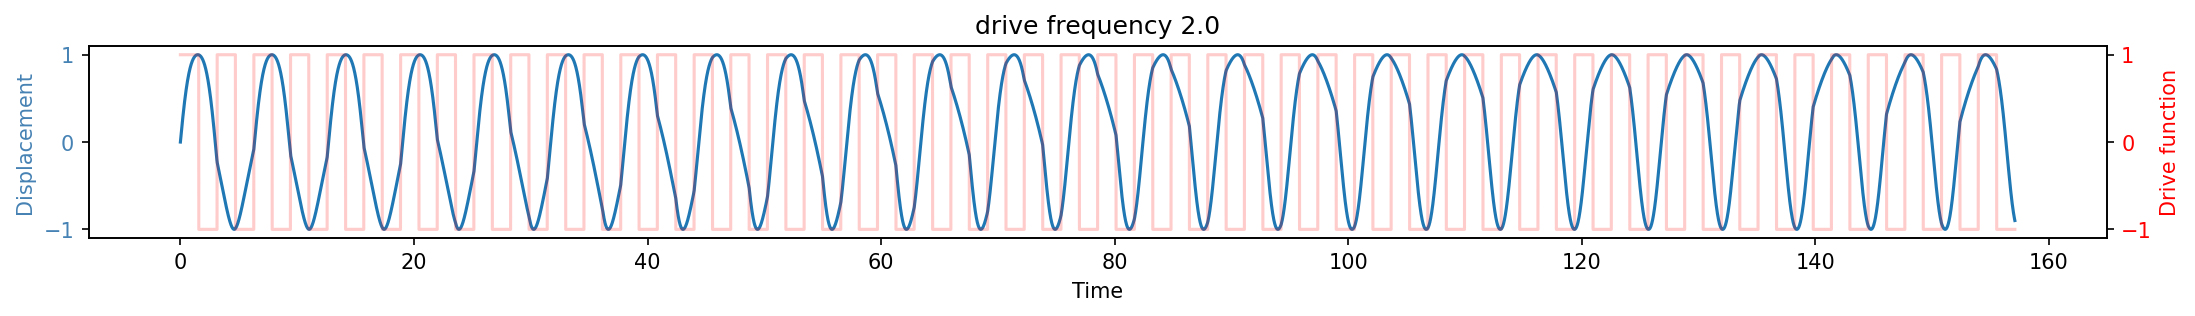

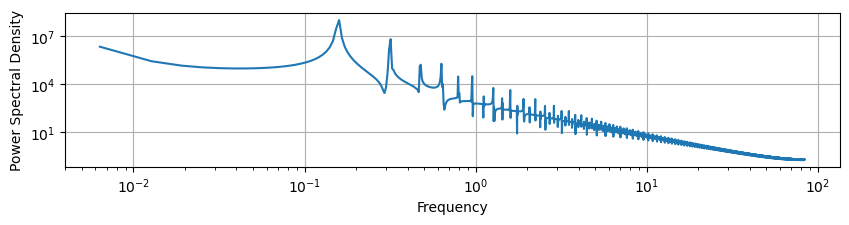

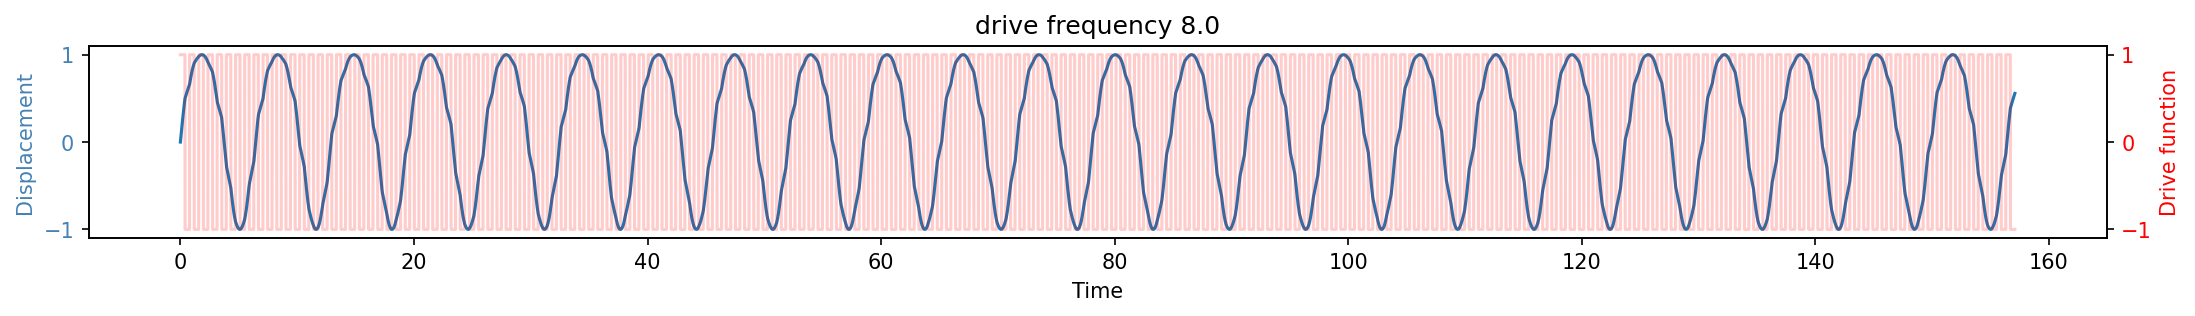

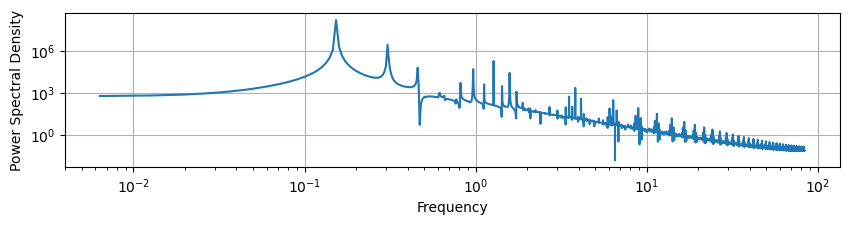

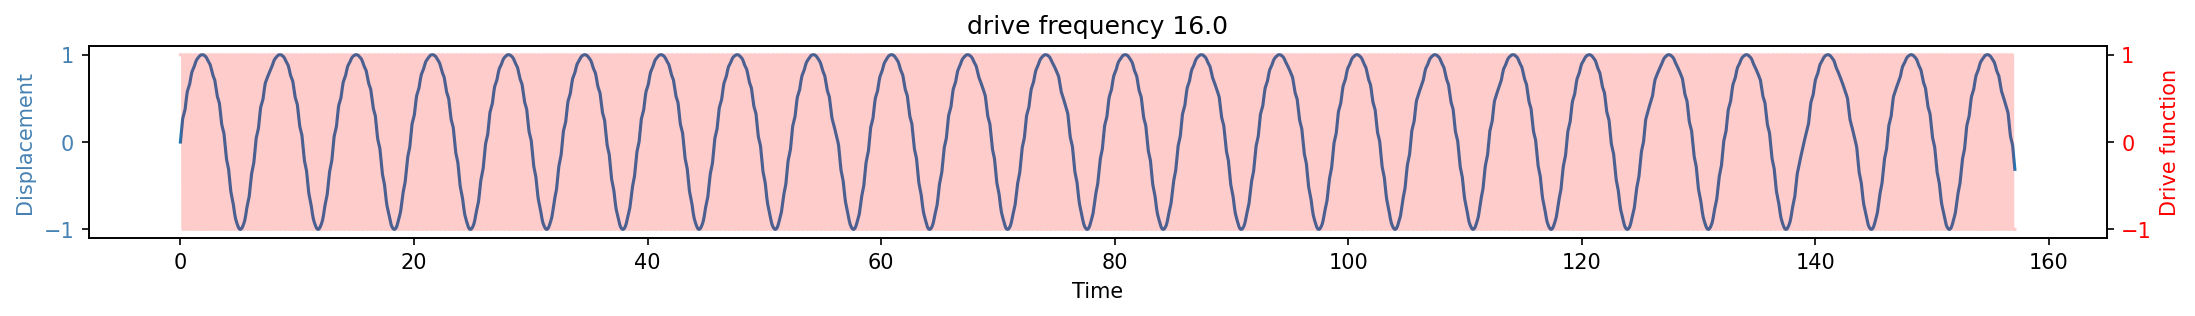

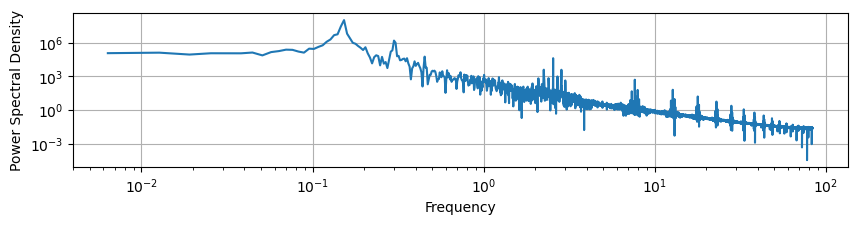

In [43]:
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]
    drive_freq = drive_frequency_array[i]
    utils.plot_obsesrvable_and_drive(traj, 
                                     drive_array = drive_array, 
                                     t_array = t_array)
    plt.title(f"drive frequency {drive_freq}")
    utils.plot_power_spectrum(t_array, traj)

In [44]:
### Save simulation as CSV

df = pd.DataFrame()
df['time'] = t_array

# Loop over the drive frequency array
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]

    # Create new columns for each drive_freq
    df[f'square_drive_{drive_freq}'] = drive_array
    df[f'response_under_{drive_freq}'] = traj

df.to_csv('simulated_data/radial_isochron_noiseless.csv', index=False)

df

time square_drive_0.25  response_under_0.25 square_drive_0.5  \
0        0.000               1.0             0.000000              1.0   
1        0.006               1.0             0.008517              1.0   
2        0.012               1.0             0.017020              1.0   
3        0.018               1.0             0.025508              1.0   
4        0.024               1.0             0.033979              1.0   
...        ...               ...                  ...              ...   
26175  157.050               1.0             0.162890              1.0   
26176  157.056               1.0             0.170993              1.0   
26177  157.062               1.0             0.179068              1.0   
26178  157.068               1.0             0.187115              1.0   
26179  157.074               1.0             0.195132              1.0   

       response_under_0.5 square_drive_0.75  response_under_0.75  \
0                0.000000               1.0             0.000000   
1                0.008517               1.0             0.008517   
2                0.017020               1.0             0.017020   
3                0.025508               1.0             0.025508   
4                0.033979               1.0             0.033979   
...                   ...               ...                  ...   
26175            0.874620              -1.0            -0.420190   
26176            0.877416              -1.0            -0.416207   
26177            0.880174              -1.0            -0.412226   
26178            0.882895              -1.0            -0.408247   
26179            0.885578              -1.0            -0.404271   

      square_drive_0.875  response_under_0.875 square_drive_0.9375  ...  \
0                    1.0              0.000000                 1.0  ...   
1                    1.0              0.008517                 1.0  ...   
2                    1.0              0.017020                 1.0  ...   
3                    1.0              0.025508                 1.0  ...   
4                    1.0              0.033979                 1.0  ...   
...                  ...                   ...                 ...  ...   
26175               -1.0             -0.300808                 1.0  ...   
26176               -1.0             -0.296919                 1.0  ...   
26177               -1.0             -0.293033                 1.0  ...   
26178               -1.0             -0.289152                 1.0  ...   
26179               -1.0             -0.285275                 1.0  ...   

       square_drive_1.125 response_under_1.125  square_drive_1.25  \
0                     1.0             0.000000                1.0   
1                     1.0             0.008517                1.0   
2                     1.0             0.017020                1.0   
3                     1.0             0.025508                1.0   
4                     1.0             0.033979                1.0   
...                   ...                  ...                ...   
26175                 1.0             0.265899                1.0   
26176                 1.0             0.273596                1.0   
26177                 1.0             0.281259                1.0   
26178                 1.0             0.288887                1.0   
26179                 1.0             0.296478                1.0   

      response_under_1.25  square_drive_2.0 response_under_2.0  \
0                0.000000               1.0           0.000000   
1                0.008517               1.0           0.008517   
2                0.017020               1.0           0.017020   
3                0.025508               1.0           0.025508   
4                0.033979               1.0           0.033979   
...                   ...               ...                ...   
26175            0.154637              -1.0          -0.883204   
26176            0.162768              -1.0   

**Case 2: Brownian noise in angular and radial components, integrated using Euler-Maruyama method**

In [45]:
sigma_r = 0.1
sigma_𝜙 = 0.1
np.random.seed(1)

drive_list = []
simulated_trajectory_list = []

for drive_f in drive_frequency_array:
    drive_func = drive_with_f(drive_f)
    oscillator = HR_Oscillators.Radial_Oscillator(drive_func, k = k,
                                                        sigma_r = sigma_r, 
                                                        sigma_𝜙 = sigma_𝜙)
    x_array, t_array = oscillator.run_with_noise([1, 0], T=T, dt=dt)
    drive_array = [drive_func(t) for t in t_array]

    simulated_trajectory_list += [x_array]
    drive_list += [drive_array]

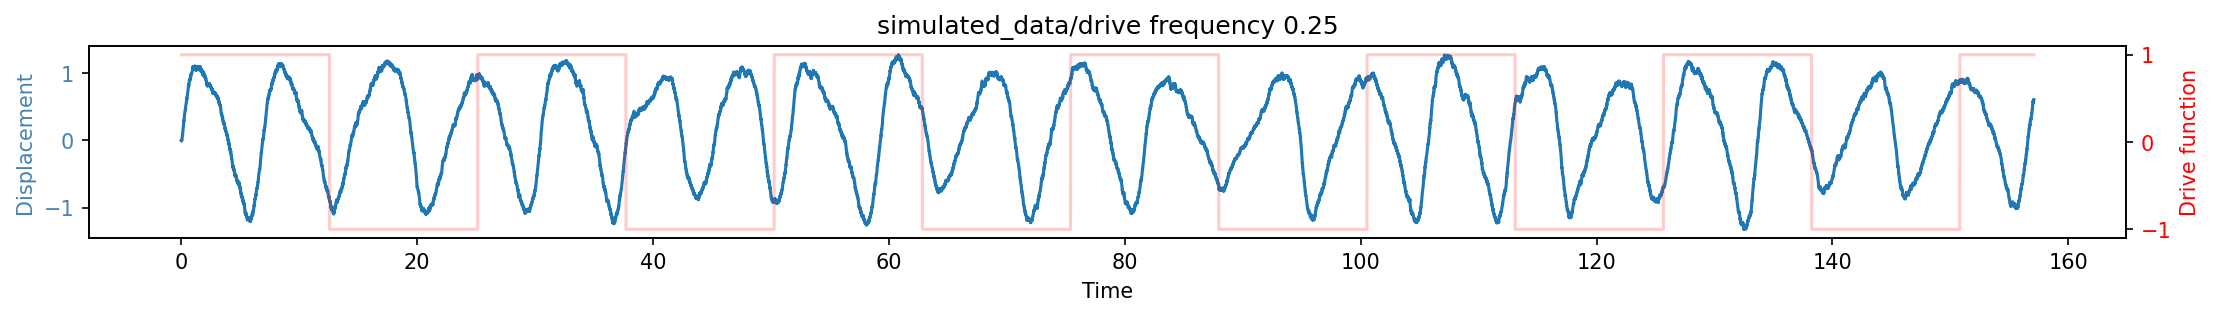

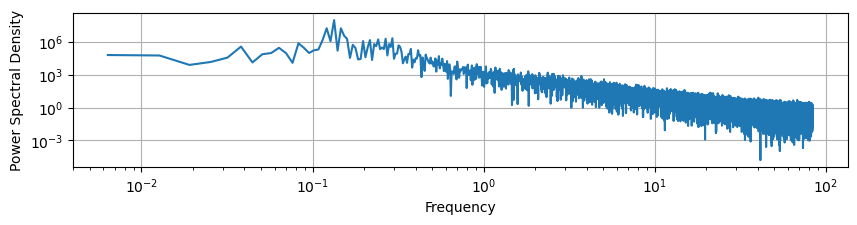

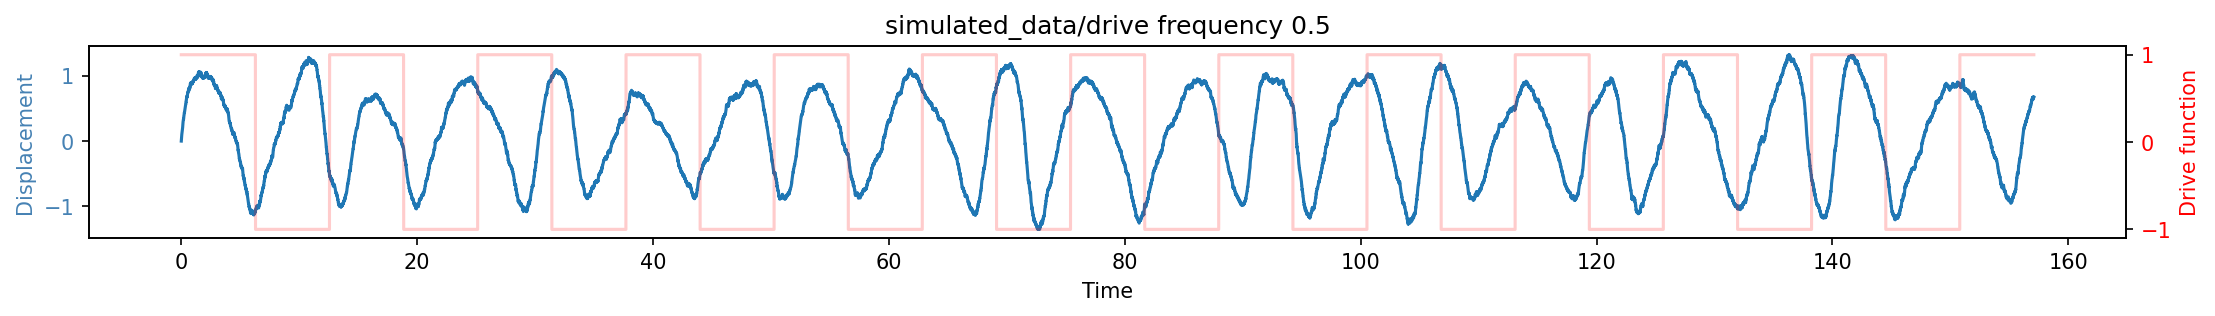

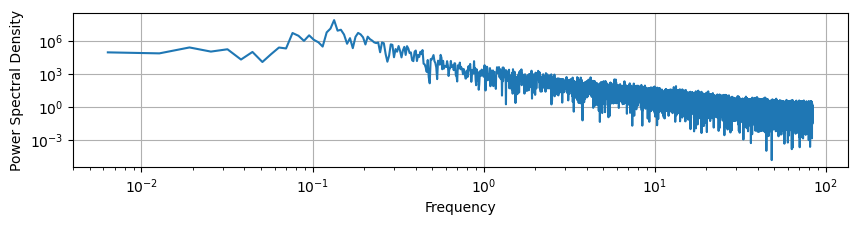

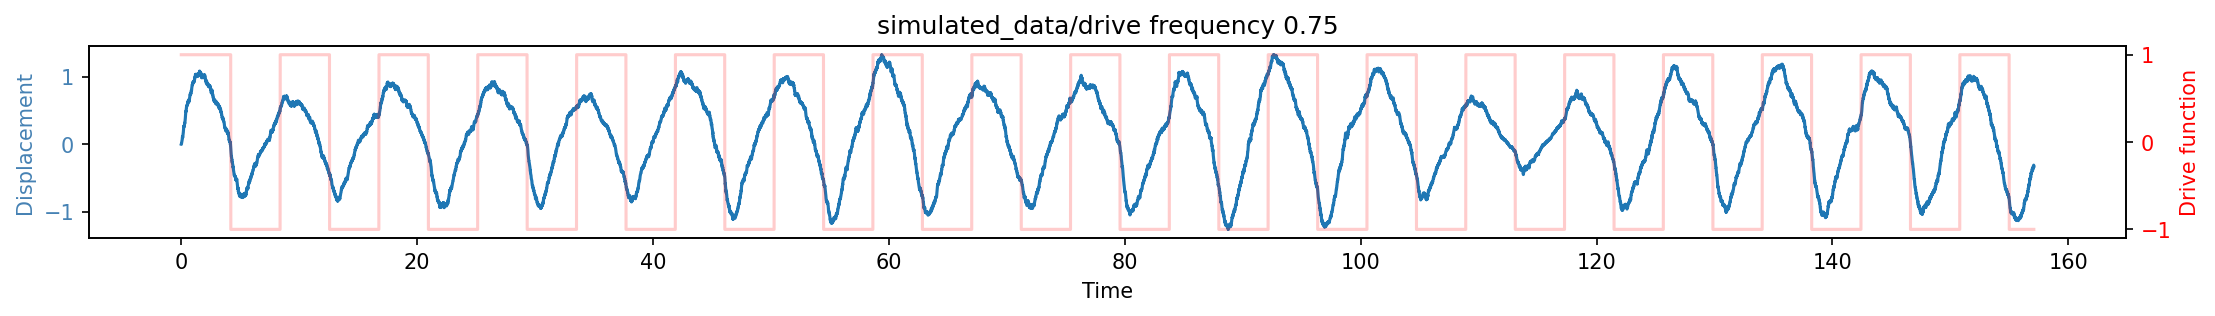

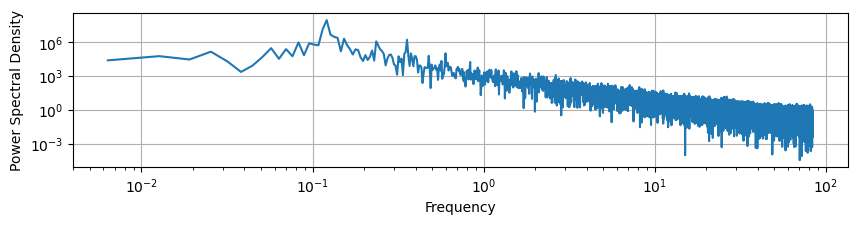

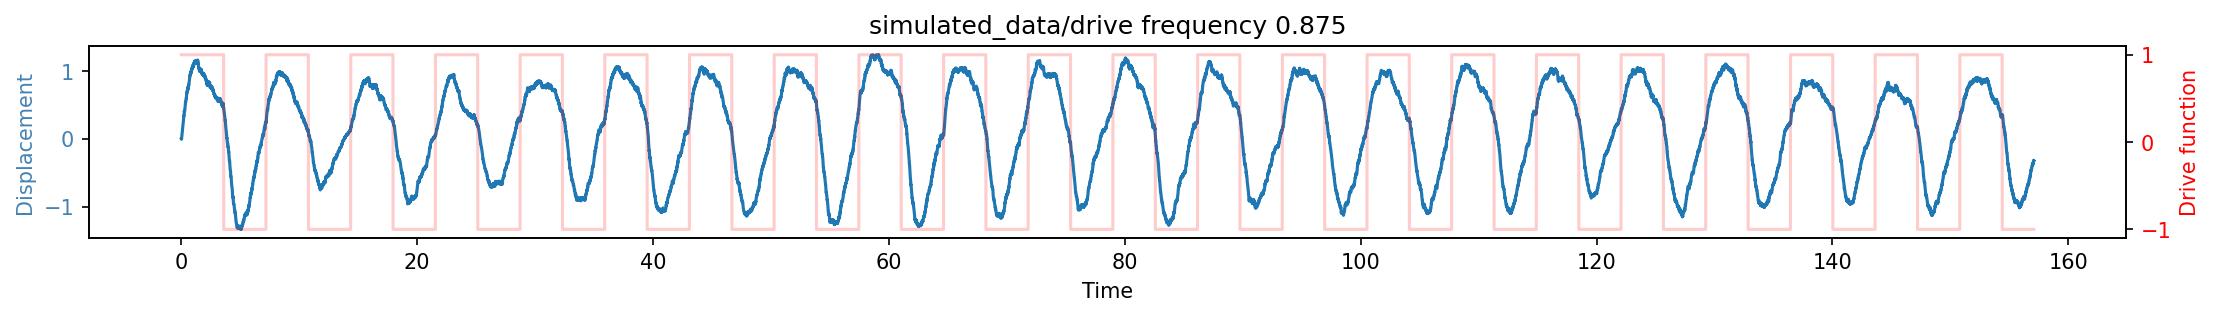

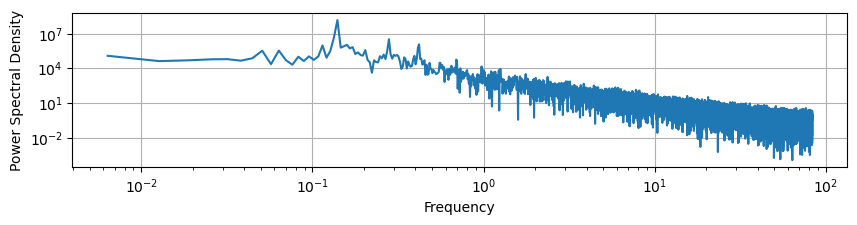

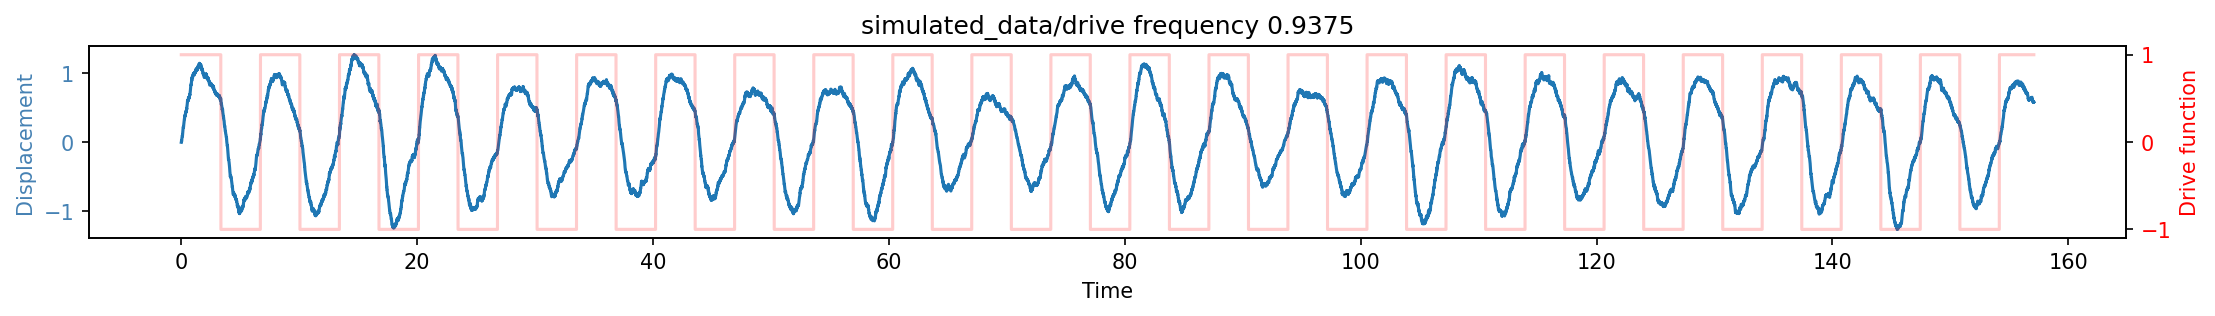

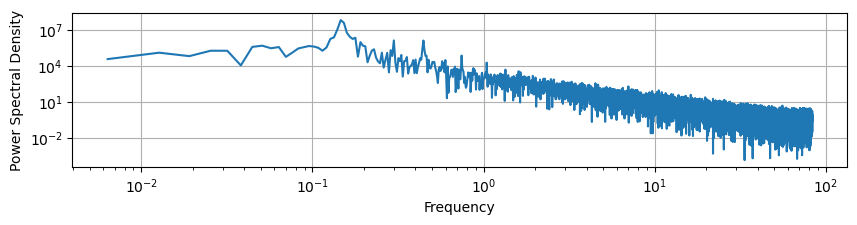

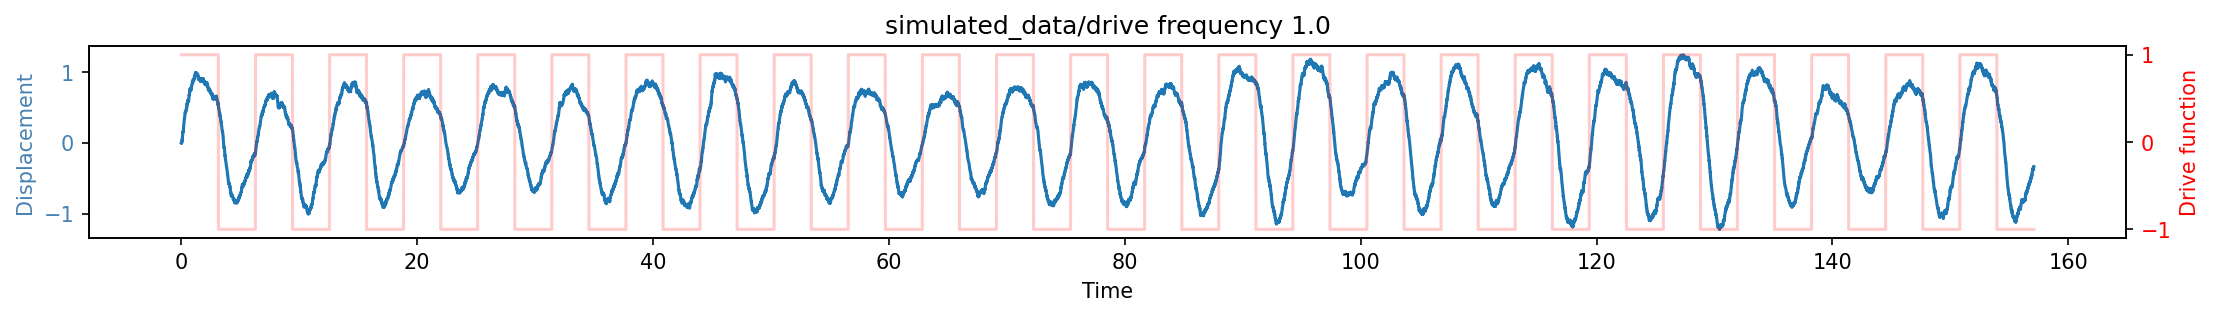

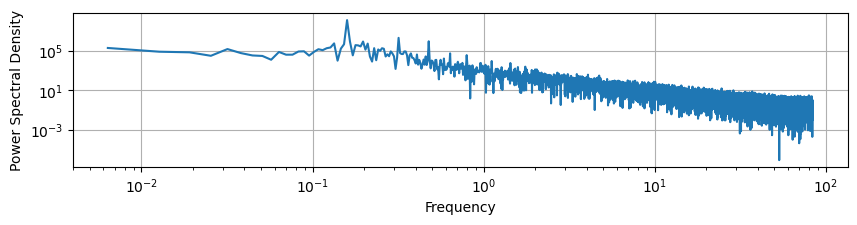

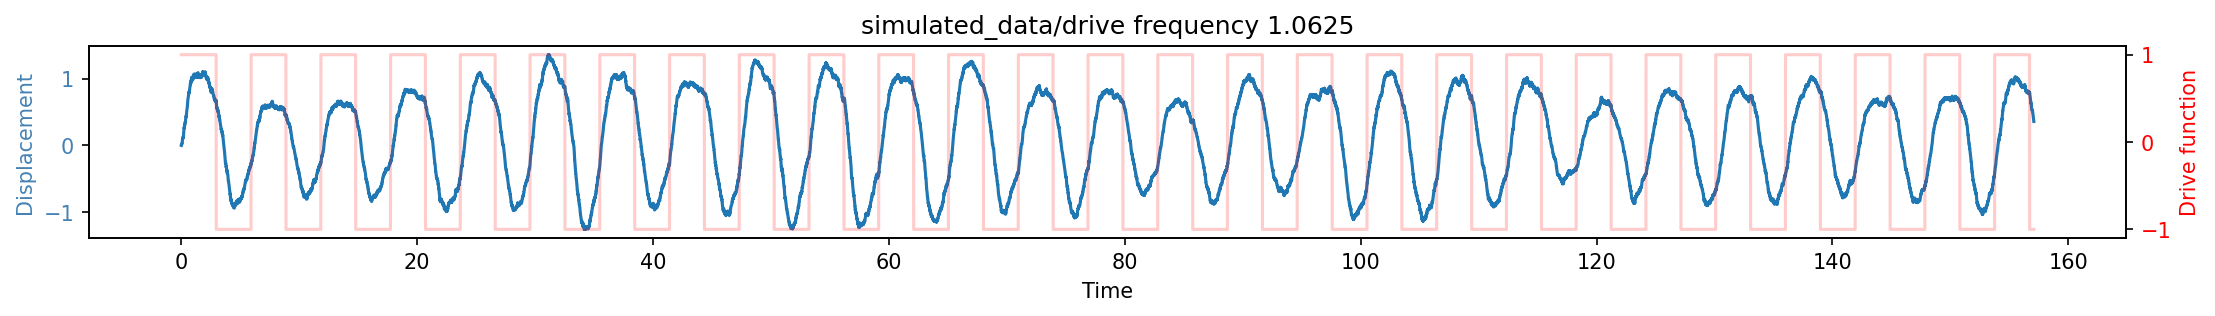

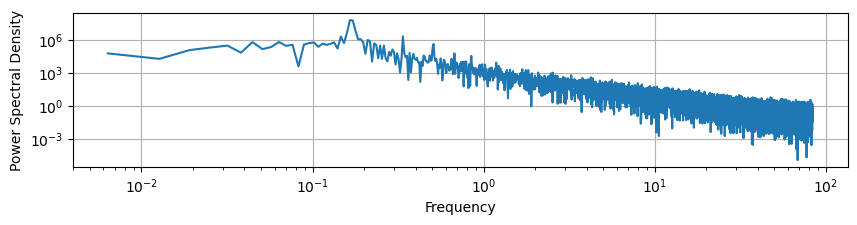

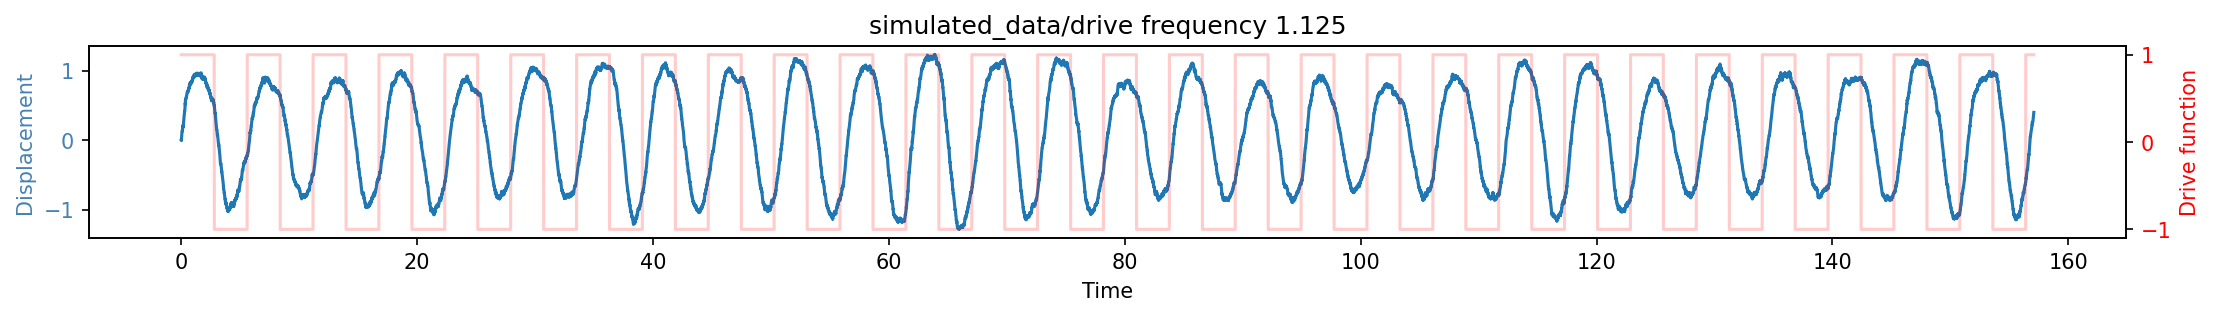

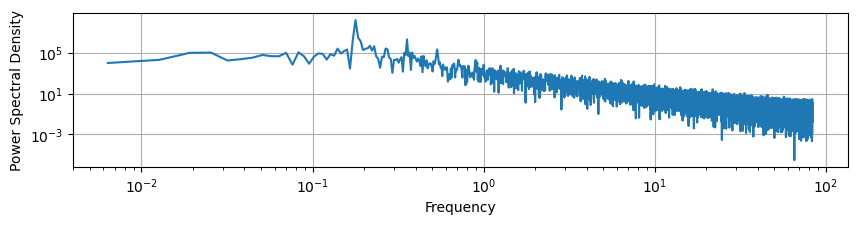

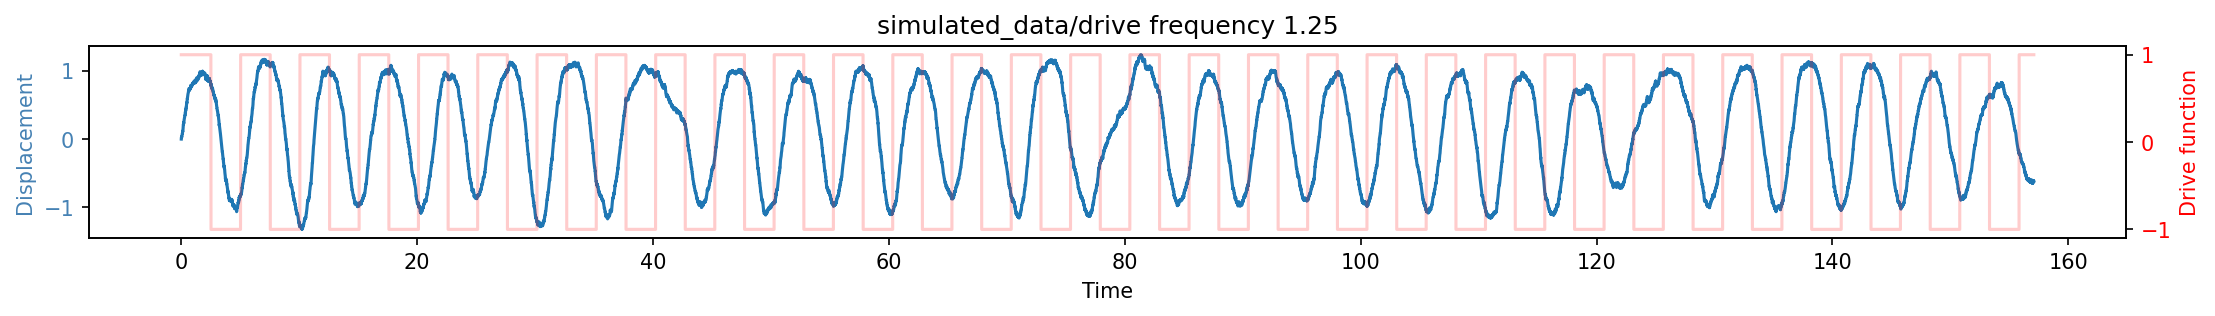

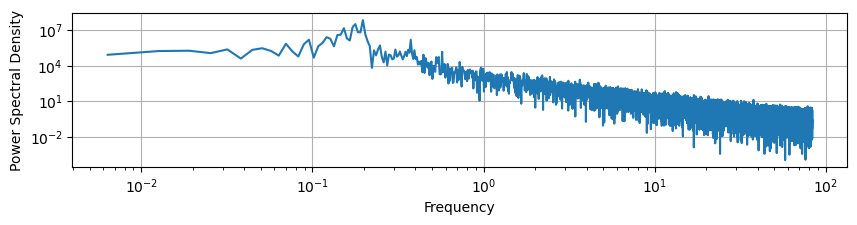

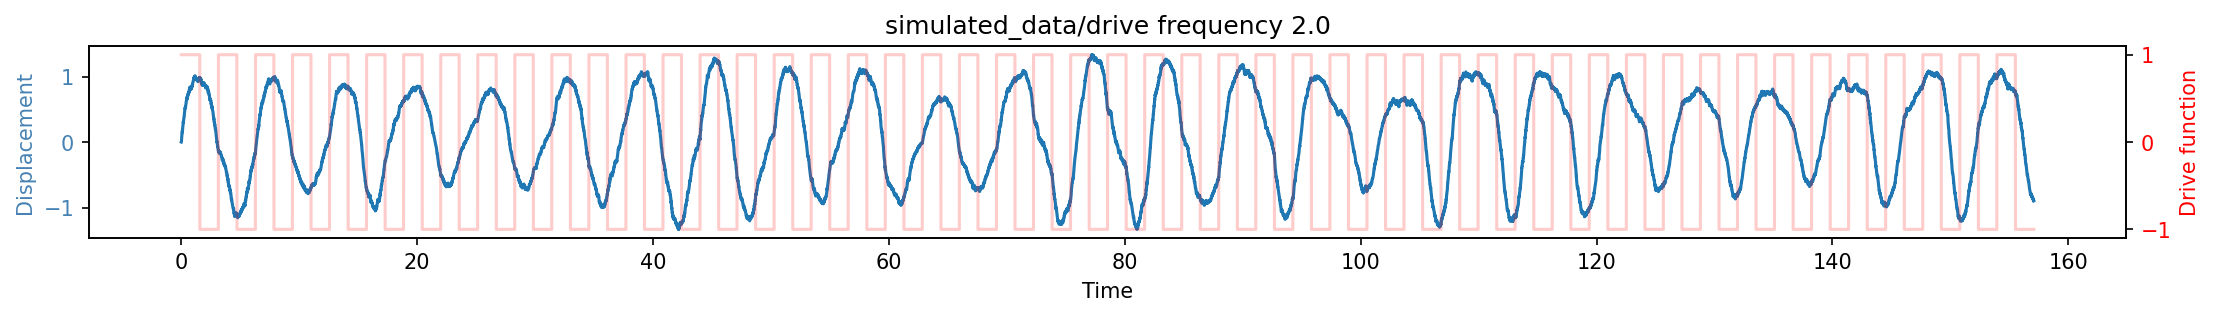

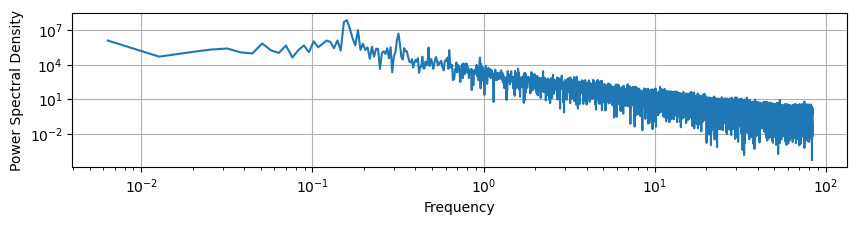

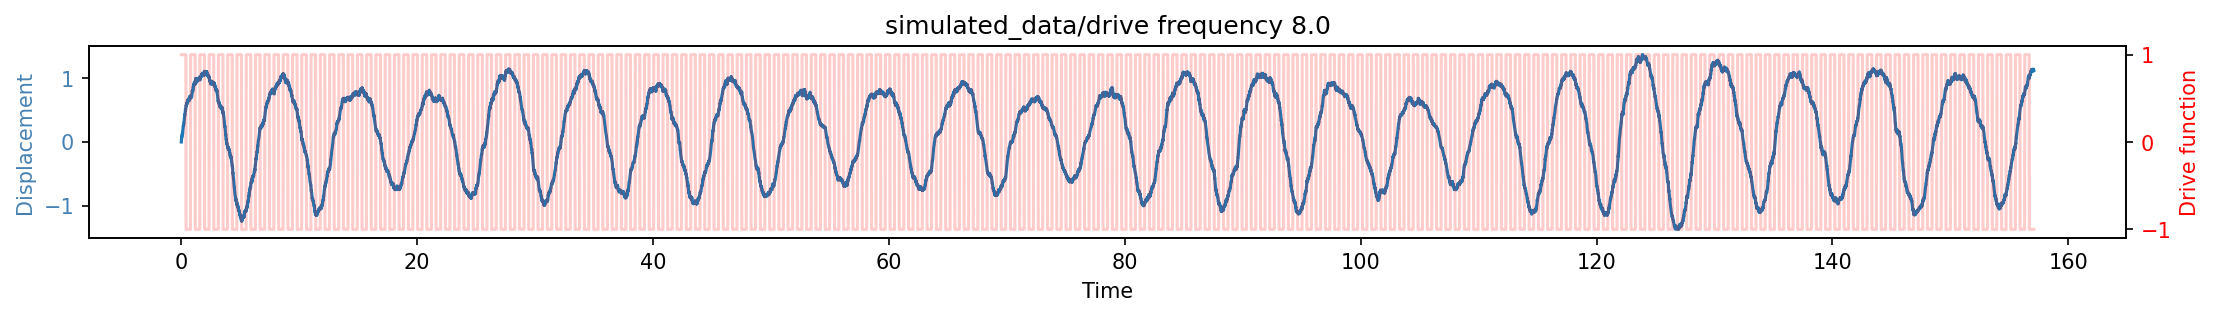

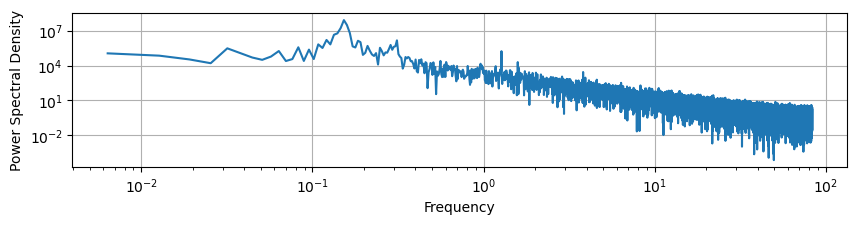

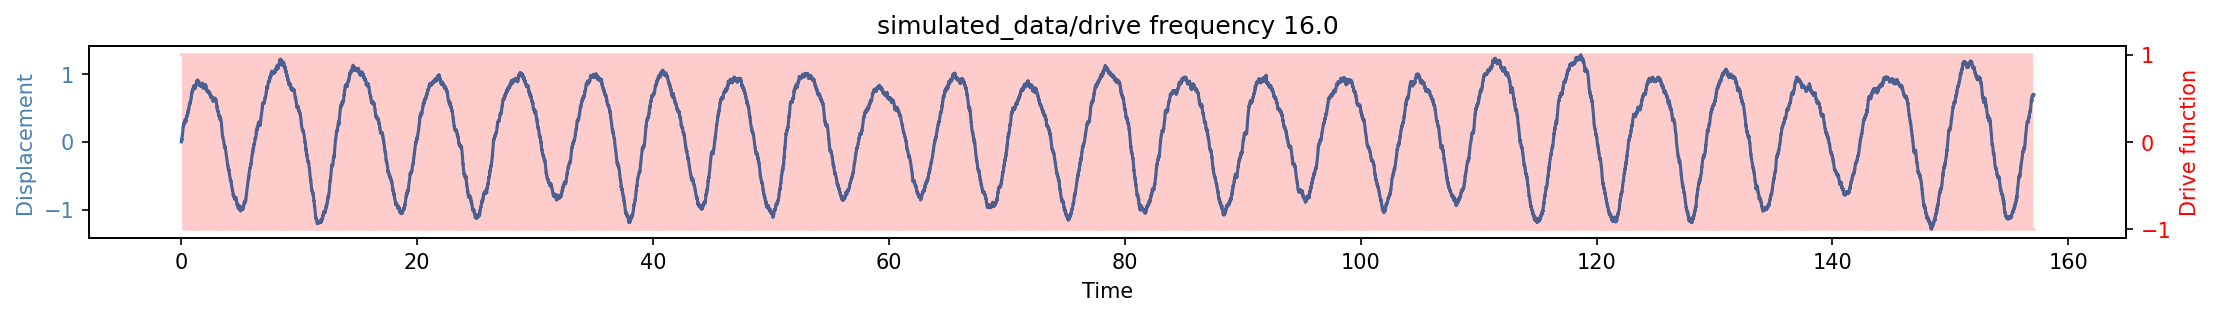

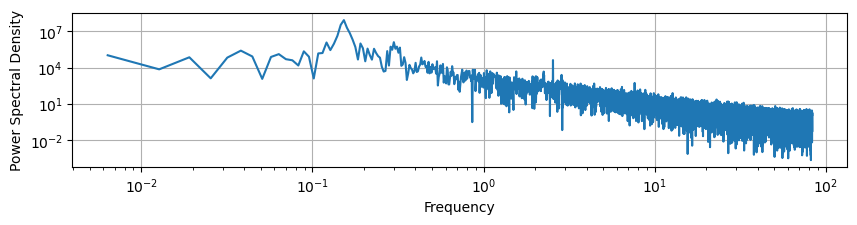

In [46]:
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]
    drive_freq = drive_frequency_array[i]
    utils.plot_obsesrvable_and_drive(traj, 
                                     drive_array = drive_array, 
                                     t_array = t_array)
    plt.title(f"simulated_data/drive frequency {drive_freq}")
    utils.plot_power_spectrum(t_array, traj)


In [47]:
df = pd.DataFrame()
df['time'] = t_array

# Loop over the drive frequency array
for i, drive_freq in enumerate(drive_frequency_array):
    traj = simulated_trajectory_list[i]
    drive_array = drive_list[i]

    # Create new columns for each drive_freq
    df[f'square_drive_{drive_freq}'] = drive_array
    df[f'response_under_{drive_freq}'] = traj

df.to_csv('simulated_data/radial_isochron_with_noise.csv', index=False)

df

time square_drive_0.25  response_under_0.25 square_drive_0.5  \
0        0.000               1.0             0.000000              1.0   
1        0.006               1.0             0.003833              1.0   
2        0.012               1.0             0.004027              1.0   
3        0.018               1.0            -0.005397              1.0   
4        0.024               1.0            -0.002757              1.0   
...        ...               ...                  ...              ...   
26175  157.050               1.0             0.565418              1.0   
26176  157.056               1.0             0.565465              1.0   
26177  157.062               1.0             0.577348              1.0   
26178  157.068               1.0             0.582729              1.0   
26179  157.074               1.0             0.604618              1.0   

       response_under_0.5 square_drive_0.75  response_under_0.75  \
0                0.000000               1.0             0.000000   
1                0.018197               1.0            -0.000431   
2                0.033294               1.0             0.005550   
3                0.044161               1.0             0.008934   
4                0.053990               1.0             0.018099   
...                   ...               ...                  ...   
26175            0.674582              -1.0            -0.323805   
26176            0.676328              -1.0            -0.313620   
26177            0.669099              -1.0            -0.308902   
26178            0.667303              -1.0            -0.323042   
26179            0.671767              -1.0            -0.324878   

      square_drive_0.875  response_under_0.875 square_drive_0.9375  ...  \
0                    1.0              0.000000                 1.0  ...   
1                    1.0             -0.002554                 1.0  ...   
2                    1.0              0.004597                 1.0  ...   
3                    1.0              0.006409                 1.0  ...   
4                    1.0              0.000563                 1.0  ...   
...                  ...                   ...                 ...  ...   
26175               -1.0             -0.321838                 1.0  ...   
26176               -1.0             -0.320267                 1.0  ...   
26177               -1.0             -0.315988                 1.0  ...   
26178               -1.0             -0.326334                 1.0  ...   
26179               -1.0             -0.324737                 1.0  ...   

       square_drive_1.125 response_under_1.125  square_drive_1.25  \
0                     1.0             0.000000                1.0   
1                     1.0            -0.002888                1.0   
2                     1.0             0.013175                1.0   
3                     1.0             0.040069                1.0   
4                     1.0             0.045235                1.0   
...                   ...                  ...                ...   
26175                 1.0             0.364478                1.0   
26176                 1.0             0.376822                1.0   
26177                 1.0             0.385483                1.0   
26178                 1.0             0.399842                1.0   
26179                 1.0             0.402575                1.0   

      response_under_1.25  square_drive_2.0 response_under_2.0  \
0                0.000000               1.0           0.000000   
1                0.020240               1.0           0.002572   
2                0.019584               1.0           0.004354   
3                0.027580               1.0           0.028267   
4                0.035086               1.0           0.057951   
...                   ...               ...                ...   
26175           -0.611854              -1.0          -0.891223   
26176           -0.616101              -1.0   